In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from statsmodels.stats.multitest import multipletests

/Users/jacobv/jakepy/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Load brainspan data

In [2]:
ls /Users/jacobv/Science/PLS_GXP/

CellsnLayers/                   PNC/
GCorr_GTexComp_ABA_C1_data.csv  media-8.xlsx
GCorr_GTexComp_ABA_C2_data.csv  media-9.xlsx
GCorr_GTexComp_ABA_C3_data.csv  refseq_conversion.csv
GTEx_IndivCongruence.csv        refseq_conversion.numbers*
GTex_harmed_GExp.csv            txfer/
Mouse/


In [7]:
df = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/gene_expression_original.csv',
                     )
rmd = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/gene_metadata_original.csv')
cmd = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/samples_metadata.csv')

In [8]:
# df = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/expression_matrix.csv',header=None)
# rmd = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/rows_metadata.csv')
# cmd = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/columns_metadata.csv')

# Load component data

In [28]:
# allcs = pandas.DataFrame(c1,copy=True)
# allcs.loc[:,'C1_expr'] = allcs.expr.values
# allcs.drop('expr',axis=1,inplace=True)
# allcs.loc[:,'C2_expr'] = c2.sort_values('gene_symbol').expr.values
# allcs.loc[:,'C3_expr'] = c3.sort_values('gene_symbol')['0'].values
# allcs.to_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/PLS_Component_Expr.csv',
#              index=False)
# allcs.head()

In [4]:
c1 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCORR_C1_genelist.csv',
                    index_col=0)
c1.columns = ['expr'] + c1.columns[1:].tolist()
c2 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C2_genelist.csv',
                    index_col=0)
c2.columns = ['expr'] + c2.columns[1:].tolist()
c2 = c2.sort_values('expr',ascending=True)
c3 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C3_genelist.csv',
                    index_col=0)


In [5]:
c1 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCORR_C1_genelist.csv',
                    index_col=0)
c1.columns = ['expr'] + c1.columns[1:].tolist()
c1 = c1.sort_values('expr',ascending=True)
c2 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C2_genelist.csv',
                    index_col=0)
c2.columns = ['expr'] + c2.columns[1:].tolist()
c2 = c2.sort_values('expr',ascending=True)
c3 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C3_genelist.csv',
                    index_col=0)
c3.columns = ['expr'] + c3.columns[1:].tolist()
c3 = c3.sort_values('expr',ascending=True)

In [9]:
len(rmd.gene_symbol.unique())

47808

#### address duplicates

In [10]:
dups = []
dind = []
catch = []
for i,row in rmd.iterrows():
    x = row['gene_symbol']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)

It appears most uniques are RNA or things we dont care about. I will remove them

In [6]:
df.shape

(52376, 525)

In [11]:
bad_index = rmd[rmd.gene_symbol.isin(dups)].index
rmd.drop(bad_index,inplace=True)
df.drop(bad_index,inplace=True)

#### harmonize genes

In [12]:
shared = list(set(rmd.gene_symbol.values) & set(c1.gene_symbol))
len(shared)

13750

In [13]:
good_ids = rmd[rmd.gene_symbol.isin(shared)].index
gxp = df.loc[good_ids]
gxp.shape

(13750, 525)

In [14]:
gxp.index = rmd[rmd.gene_symbol.isin(shared)].gene_symbol.values
gxp.drop(gxp.columns[0],axis=1,inplace=True) # get rid of index column
gxp.head()

,0,1,2,3,4,5,6,7,8,9,...,514,515,516,517,518,519,520,521,522,523
TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,44.943915,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,38.157569,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,3.609830,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,3.560650,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859
FGR,0.244174,0.266976,0.248188,0.141398,0.467688,0.296493,0.079941,0.149822,0.204210,0.260205,...,1.319251,2.062175,1.168233,0.681609,0.490367,0.407953,1.568014,1.260039,1.736395,1.632879


#### Get gene expression for each component and each columns

In [15]:
gdf = pandas.DataFrame(cmd,copy=True)

In [16]:
c1.index = c1.gene_symbol.values
c2.index = c2.gene_symbol.values
c3.index = c3.gene_symbol.values
for i,col in enumerate(gxp.columns):
    gdf.loc[i,'C1_exp'] = np.dot(gxp[col],
                                 c1.loc[gxp.index,'expr'].values)
    gdf.loc[i,'C2_exp'] = np.dot(gxp[col],
                                 c2.loc[gxp.index,'expr'].values)
    gdf.loc[i,'C3_exp'] = np.dot(gxp[col],
                                 c3.loc[gxp.index,'expr'].values)

In [13]:
#gdf.to_csv('~/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/GCorr_Brainspan.csv')

In [2]:
gdf = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_Brainspan.csv')

#### Prepare stuff for plots

In [17]:
order = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw','4 mos','10 mos',
         '1 yrs', '2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']

# stage
fetal = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw',]
infant = ['4 mos','10 mos','1 yrs',]
child = ['2 yrs', '3 yrs','4 yrs','8 yrs','11 yrs']
adolescent = ['11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',]
adult = ['21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Stage'] = name

#epoch
e0 = ['8 pcw', '9 pcw']
e1 = ['12 pcw', '13 pcw', '16 pcw', '17 pcw', '19 pcw']
e2 = ['21 pcw','24 pcw', '25 pcw', '26 pcw', '35 pcw', 
      '37 pcw','4 mos']
e3 = ['10 mos','1 yrs','2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [e0,e1,e2,e3]
names = ['e0','e1','e2','e3']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Epoch'] = name

#period
p2 = ['8 pcw', '9 pcw']
p3 = ['12 pcw', '13 pcw',]
p4 = ['16 pcw']
p5 = ['17 pcw', '19 pcw']
p6 = ['21 pcw','24 pcw']
p7 = ['25 pcw', '26 pcw', '35 pcw','37 pcw']
p8 = ['4 mos']
p9 = ['10 mos','1 yrs']
p10 = ['2 yrs', '3 yrs','4 yrs',]
p11 = ['8 yrs','11 yrs',]
p12 = ['13 yrs', '15 yrs', '18 yrs', '19 yrs','21 yrs',
       '23 yrs','30 yrs', '36 yrs', '37 yrs','40 yrs']
divs = [p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
names = ['p2','p3','p4','p5','p6','p7','p8','p9',
         'p10','p11','p12']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Period'] = name


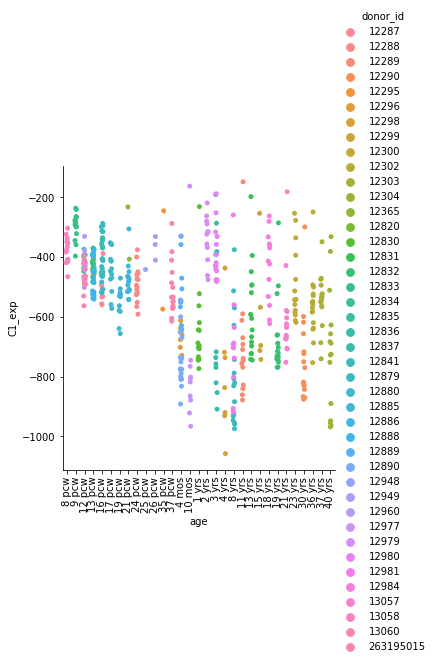

In [30]:
g = sns.catplot(x='age',y='C1_exp',data=gdf,order=order,
               hue='donor_id')
g.set_xticklabels(rotation=90)

In [66]:
list(zip(gdf.structure_acronym.unique(),
        gdf.structure_name.unique()))

[('Ocx', 'occipital neocortex'),
 ('M1C-S1C', 'primary motor-sensory cortex (samples)'),
 ('AMY', 'amygdaloid complex'),
 ('MGE', 'medial ganglionic eminence'),
 ('STC', 'posterior (caudal) superior temporal cortex (area 22c)'),
 ('URL', 'upper (rostral) rhombic lip'),
 ('CGE', 'caudal ganglionic eminence'),
 ('DTH', 'dorsal thalamus'),
 ('MFC', 'anterior (rostral) cingulate (medial prefrontal) cortex'),
 ('DFC', 'dorsolateral prefrontal cortex'),
 ('OFC', 'orbital frontal cortex'),
 ('LGE', 'lateral ganglionic eminence'),
 ('ITC', 'inferolateral temporal cortex (area TEv, area 20)'),
 ('HIP', 'hippocampus (hippocampal formation)'),
 ('VFC', 'ventrolateral prefrontal cortex'),
 ('PCx', 'parietal neocortex'),
 ('TCx', 'temporal neocortex'),
 ('A1C', 'primary auditory cortex (core)'),
 ('V1C', 'primary visual cortex (striate cortex, area V1/17)'),
 ('STR', 'striatum'),
 ('M1C', 'primary motor cortex (area M1, area 4)'),
 ('IPC', 'posteroventral (inferior) parietal cortex'),
 ('S1C', 'pri

In [4]:
Occipital =  ['Ocx','V1C']
Somatomotor=['M1C-S1C','M1C','S1C']
Limbic=['AMY','HIP']
GangEm= ['MGE','CGE','LGE']
Temporal=['STC','ITC','TCx','A1C']
Cerebellum=['URL','CB','CBC']
Subcortex=['DTH','STR','MD']
Frontal=['MFC','DFC','OFC','VFC']
Parietal=['PCx','IPC']

Striatum = ['STR']
Thalamus = ['MD','DTH']
             
divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Subcortex,Frontal,Parietal]
names = ['Occipital','Somatomotor','Limbic','GangEm','Temporal','Cerebellum','Subcortex','Frontal','Parietal']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure'] = name

divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Frontal,Parietal,Striatum,Thalamus]
names = ['Occipital','Sensorimotor','Limbic','GangEm','Temporal','Cerebellum','Frontal','Parietal','Striatum','Thalamus']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure2'] = name
    
Tele = ['Ocx','AMY','M1C-S1C','MGE','STC',
                  'CGE','DTH','MFC','DFC','OFC','LGE',
                  'ITC','HIP','VFC','PCx','TCx','IPC',
                  'A1C','V1C','STR','M1C','S1C','MD']
Met = ['URL','CB','CBC']
divs = [Tele,Met]
names = ['Tele','Met']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'NT_Segment'] = name

Sensory = ['M1C-S1C','A1C','V1C','M1C','S1C']
Association = ['Ocx','AMY','STC','MFC',
            'DFC','OFC','ITC','HIP',
            'VFC','PCx','TCx','IPC']
Not_Cortex = ['MGE','URL','CGE','DTH',
          'LGE','STR','CB','CBC','MD']
divs = [Sensory,Association,Not_Cortex]
names = ['Sensory','Association','Not_Cortex']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'Sensorifugal'] = name


In [4]:
# gdf = pandas.read_csv('~/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/GCorr_Brainspan.csv',
#                      index_col=0)

#### Mixed models

In [5]:
import statsmodels.formula.api as smf

In [66]:
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num) / 4.35
    elif measure == 'yrs':
        fage = int(num) * 12
    else:
        fage = int(num)
    gdf.loc[i,'age_in_months'] = fage

In [105]:
4.345 * 9

39.105

In [106]:
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num)
    elif measure == 'yrs':
        fage = (int(num) * 52) + 39.105
    else:
        fage = (int(num) * 4.345) + 39.105
    gdf.loc[i,'age_in_weeks'] = fage

In [107]:
gdf.loc[:,'log_age_months'] = np.log(gdf['age_in_months']).values
gdf.loc[:,'log_age_weeks'] = np.log(gdf['age_in_weeks']).values


In [68]:
gdf.loc[:,'log_age_sq'] = (gdf['log_age_months']**2).values

In [79]:
# import statsmodels.api as sm
# vcf = {"tissue": "0+C(MacroStructure)"}
# model = sm.MixedLM.from_formula("C1_exp ~ 1", groups="donor_id",
#                                 re_formula="1", vc_formula=vcf, data=gdf
#                                ).fit()

In [97]:
mod = smf.mixedlm("C1_exp ~ log_age_months*NT_Segment + log_age_sq*NT_Segment",
                  data=gdf,
                   groups=gdf['donor_id'].astype(str)).fit()

In [98]:
mod.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:                     MixedLM          Dependent Variable:          C1_exp    
No. Observations:          524              Method:                      REML      
No. Groups:                42               Scale:                       8145.7384 
Min. group size:           1                Log-Likelihood:              -3141.0510
Max. group size:           16               Converged:                   Yes       
Mean group size:           12.5                                                    
-----------------------------------------------------------------------------------
                                    Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------------------
Intercept                          -491.231   92.728 -5.298 0.000 -672.975 -309.488
NT_Segment[T.Tele]                  198.653   63.405  3.133 0.002   74.381  322.925
log_age_months                      141.167   72.249  1.954 0.051   -0.439  282.772
log_age_months:NT_Segment[T.Tele]  -307.423   48.299 -6.365 0.000 -402.086 -212.759
log_age_sq                          -18.429   10.500 -1.755 0.079  -39.009    2.151
log_age_sq:NT_Segment[T.Tele]        36.785    6.987  5.265 0.000   23.090   50.479
Group Var                         12475.499   34.738                               
===================================================================================

"""

In [101]:
jnk = pandas.DataFrame(gdf[['age','age_in_months','age_level',
                           'Age_Stage','C1_exp','NT_Segment',
                           'log_age_months','log_age_sq']],
                      copy=True)
jnk.loc[:,'predC1'] = mod.predict(gdf)

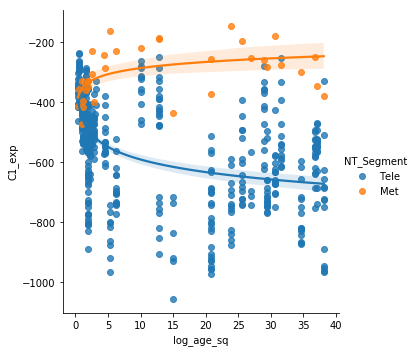

In [102]:
sns.lmplot(x='log_age_sq',y='C1_exp',data=jnk,hue='NT_Segment',
           logx=True)

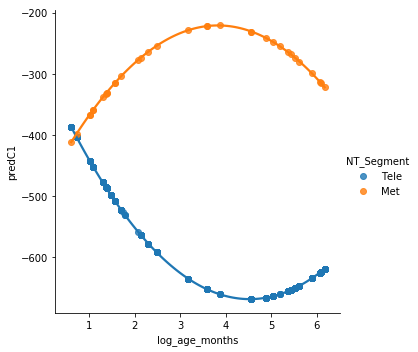

In [103]:
sns.lmplot(x='log_age_months',y='predC1',data=jnk,hue='NT_Segment',order=2)

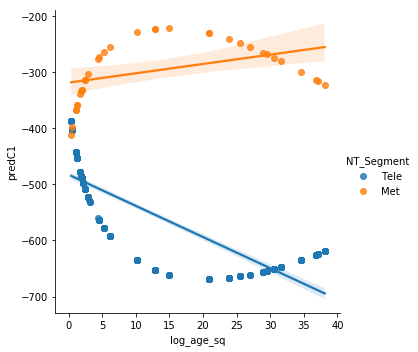

In [89]:
sns.lmplot(x='log_age_sq',y='predC1',data=jnk,hue='NT_Segment',)

#### Plot

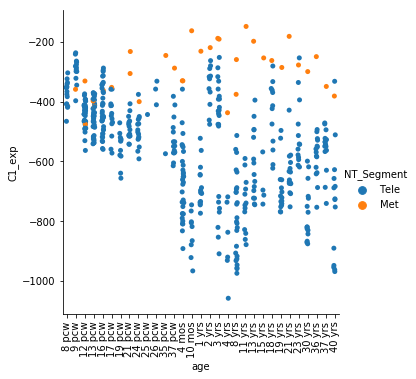

In [32]:
g = sns.catplot(x='age',y='C1_exp',data=gdf,order=order,
               hue='NT_Segment')
g.set_xticklabels(rotation=90)

In [33]:
gdf.columns

Index(['column_num', 'donor_id', 'donor_name', 'age', 'gender', 'structure_id',
       'structure_acronym', 'structure_name', 'C1_exp', 'C2_exp', 'C3_exp',
       'Age_Stage', 'Age_Epoch', 'Age_Period', 'MacroStructure',
       'MacroStructure2', 'NT_Segment', 'Sensorifugal'],
      dtype='object')

In [61]:
as_order = ['fetal','infant','child','adolescent','adult']
ae_order = sorted(gdf.Age_Epoch.unique())
ap_order = gdf.Age_Period.unique()

In [62]:
code = dict(zip(gdf.age.unique(),range(len(gdf.age.unique()))))
gdf.loc[:,'age_level'] = [code[x] for x in gdf.age.values]

In [12]:
for x in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==x]['age_level'].values
    print('%s: min=%s, max=%s'%(x,np.min(levels),np.max(levels)))

fetal: min=0, max=12
infant: min=13, max=15
child: min=16, max=19
adolescent: min=20, max=24
adult: min=25, max=30


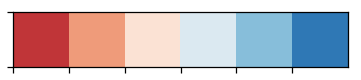

In [121]:
sns.palplot(sns.color_palette('RdBu'))

In [13]:
rbpal = [sns.color_palette('RdBu')[0],
                      sns.color_palette('RdBu')[-1]]

In [151]:
list(zip(range(len(gdf.age.unique())),gdf.age.unique()))

[(0, '8 pcw'),
 (1, '9 pcw'),
 (2, '12 pcw'),
 (3, '13 pcw'),
 (4, '16 pcw'),
 (5, '17 pcw'),
 (6, '19 pcw'),
 (7, '21 pcw'),
 (8, '24 pcw'),
 (9, '25 pcw'),
 (10, '26 pcw'),
 (11, '35 pcw'),
 (12, '37 pcw'),
 (13, '4 mos'),
 (14, '10 mos'),
 (15, '1 yrs'),
 (16, '2 yrs'),
 (17, '3 yrs'),
 (18, '4 yrs'),
 (19, '8 yrs'),
 (20, '11 yrs'),
 (21, '13 yrs'),
 (22, '15 yrs'),
 (23, '18 yrs'),
 (24, '19 yrs'),
 (25, '21 yrs'),
 (26, '23 yrs'),
 (27, '30 yrs'),
 (28, '36 yrs'),
 (29, '37 yrs'),
 (30, '40 yrs')]

Text(30, -1200, '40 yrs')

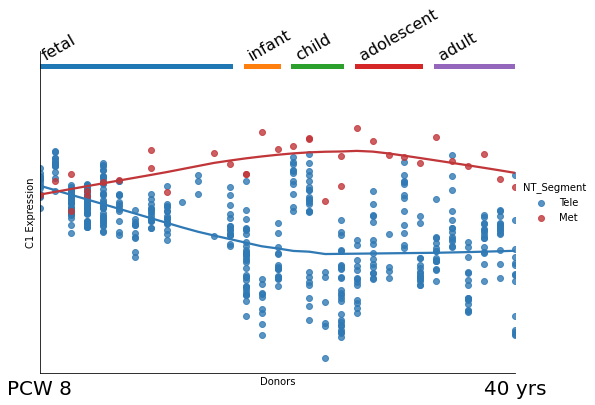

In [14]:
g = sns.lmplot(x='age_level',y='C1_exp',aspect=1.5,
               data=gdf,
               #[gdf['C1_exp']<1000],
           hue='NT_Segment',lowess=True,
              palette=rbpal[::-1])
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['age_level'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[100,100],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,110,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C1 Expression')
plt.yticks([])
plt.xlabel('Donors')
plt.xticks([])
plt.text(0,-1200,'PCW 8',fontsize=20,ha='center')
plt.text(30,-1200,'40 yrs',fontsize=20,ha='center')
#plt.xticks(ticks = range(len(gdf.age_level.unique())),
              #labels=order
          #)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BS_Devel_C1.pdf',
#    bbox_inches='tight')

Text(30, -400, '40 yrs')

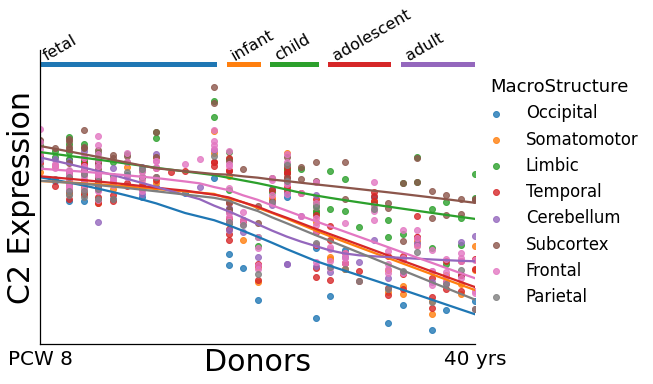

In [16]:
sns.set_context('notebook',font_scale=1.5)
g = sns.lmplot(x='age_level',y='C2_exp',aspect=1.5,
               data=gdf[(gdf.MacroStructure!='GangEm') &\
                        (gdf['C2_exp']<1000)],
           hue='MacroStructure',lowess=True,
              palette='tab10')
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['age_level'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[500,500],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,500,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C2 Expression',fontsize=30)
plt.yticks([])
plt.xlabel('Donors',fontsize=30)
plt.xticks([])
plt.text(0,-400,'PCW 8',fontsize=20,ha='center')
plt.text(30,-400,'40 yrs',fontsize=20,ha='center')
#plt.xticks(ticks = range(len(gdf.age_level.unique())),
              #labels=order
          #)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BS_Devel_C2.pdf',
#    bbox_inches='tight')

Text(30, -700, '40 yrs')

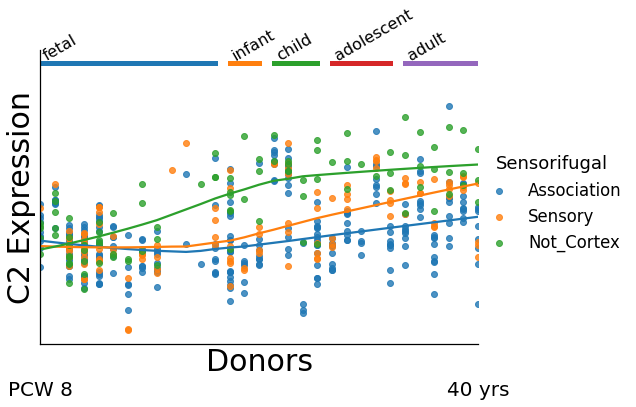

In [17]:
sns.set_context('notebook',font_scale=1.5)
g = sns.lmplot(x='age_level',y='C3_exp',aspect=1.5,
               data=gdf[gdf.C3_exp<400],
           hue='Sensorifugal',lowess=True,
              palette='tab10')
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['age_level'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[150,150],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,150,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C2 Expression',fontsize=30)
plt.yticks([])
plt.xlabel('Donors',fontsize=30)
plt.xticks([])
plt.text(0,-700,'PCW 8',fontsize=20,ha='center')
plt.text(30,-700,'40 yrs',fontsize=20,ha='center')
#plt.xticks(ticks = range(len(gdf.age_level.unique())),
              #labels=order
          #)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BS_Devel_C2.pdf',
#    bbox_inches='tight')

In [36]:
# fdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/'
# reg_types = ['MacroStructure', 'Sensorifugal']
# for comp in ['C1','C2','C3']:
#     for reg_type in reg_types:
#         g = sns.lmplot(x='age_level',y='%s_exp'%comp,
#                        data=gdf[gdf['%s_exp'%comp]<1000],
#                    hue=reg_type,lowess=True)
#         g.set_xticklabels(rotation=90)
#         plt.xticks(ticks = range(len(gdf.age_level.unique())),
#                   labels=order)
#         #plt.savefig(os.path.join(fdir,'C%s_%s_AllAge.pdf'%(comp,reg_type)),
#         #                         bbox_inches='tight')
#         plt.show()

#         for at,aord in age_types.items():
#             sns.pointplot(x=at,y='%s_exp'%comp,
#                           data=gdf[gdf['%s_exp'%comp]<1000],
#                    hue=reg_type,order=aord,)
#             sns.stripplot(x=at,y='%s_exp'%comp,alpha=0.3,
#                           data=gdf[gdf['%s_exp'%comp]<1000],
#                            hue=reg_type,order=aord)
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# #             plt.savefig(os.path.join(fdir,'C%s_%s_%s.pdf'%(comp,reg_type,at)),
# #                                  bbox_inches='tight') 
#             plt.show()

In [37]:
gdf.columns

Index(['Unnamed: 0', 'column_num', 'donor_id', 'donor_name', 'age', 'gender',
       'structure_id', 'structure_acronym', 'structure_name', 'C1_exp',
       'C2_exp', 'C3_exp', 'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_in_months', 'age_level'],
      dtype='object')

In [64]:
for i,row in gdf.iterrows():
    if row['Age_Epoch'] in ['e0','e1']:
        ag = 'Early_Prenatal'
    elif row['Age_Epoch'] == 'e3':
        ag = 'Perinatal'
    else:
        meas = row['age'].split(' ')[0]
        if int(meas) < 11:
            ag = 'Child'
        else:
            ag = 'Adolescent/Adult'
    gdf.loc[i,'new_age_gp'] = ag

for i,row in gdf.iterrows():
    if row['Age_Stage'] in ['infant','child']:
        ag = 'Infant/Child'
    elif row['Age_Stage'] in ['adolescent','adult']:
        ag = 'Adolescent/Adult'
    else:
        ag = row['Age_Stage']
    gdf.loc[i,'new_age_stage'] = ag

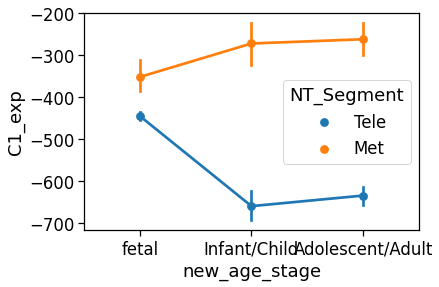

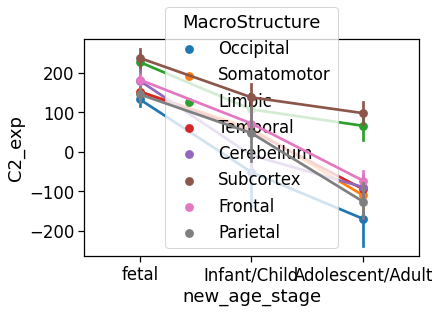

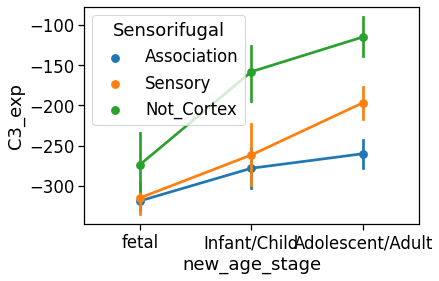

In [19]:
order = ['fetal','Infant/Child','Adolescent/Adult']
sns.pointplot(x='new_age_stage',y='C1_exp',hue='NT_Segment',
             data=gdf, order=order)
plt.show()
sns.pointplot(x='new_age_stage',y='C2_exp',hue='MacroStructure',
             data=gdf[gdf.MacroStructure!='GangEm'], order=order)
plt.show()
sns.pointplot(x='new_age_stage',y='C3_exp',hue='Sensorifugal',
             data=gdf, order=order)
plt.show()




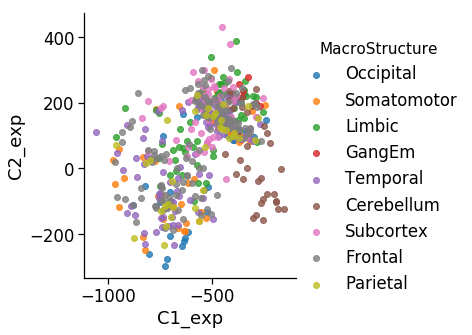

In [58]:
sns.lmplot('C1_exp','C2_exp',data=gdf,hue='MacroStructure',
           fit_reg=False)

#### Individual subject alignment

# G Tracking

In [16]:
gtrack = pandas.DataFrame(gdf,copy=True)

In [17]:
from sklearn.preprocessing import StandardScaler

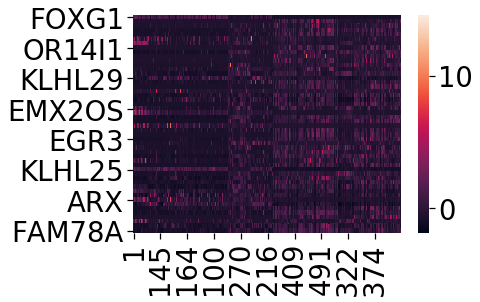

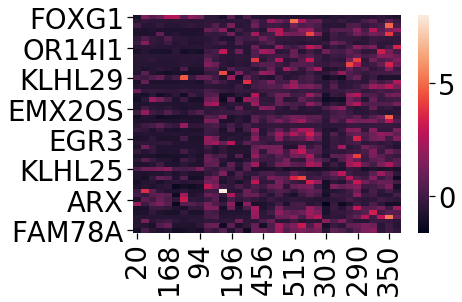

In [103]:
telelist = gdf[gdf.NT_Segment=='Tele'].index
metlist = gdf[gdf.NT_Segment=='Met'].index
jnk = pandas.DataFrame(gxp.reindex(c1.index).dropna().iloc[:50],copy=True)
jnk = pandas.DataFrame(StandardScaler().fit_transform(jnk.T).T,
                       index=jnk.index,columns=jnk.columns)
jnk = jnk[jnk.columns[gdf.Age_Epoch.sort_values().index]]
# scaler = StandardScaler()
# jnk = pandas.DataFrame(scaler.fit_transform(jnk.values),
#                       index=jnk.index,columns=jnk.columns)
sns.heatmap(jnk[[x for x in jnk.columns if x in telelist]])
plt.show()
sns.heatmap(jnk[[x for x in jnk.columns if x in metlist]])
plt.show()

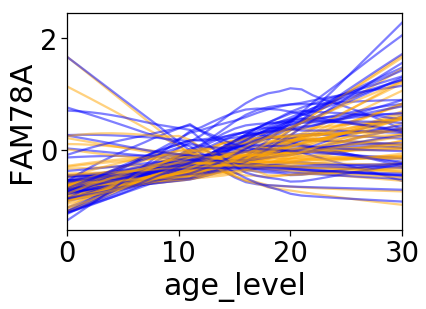

In [102]:
telelist = gdf[gdf.NT_Segment=='Tele'].index
metlist = gdf[gdf.NT_Segment=='Met'].index
plotr = pandas.DataFrame(gxp.reindex(c1.index).dropna().iloc[:50],
                         copy=True
                        ).T
scaler = StandardScaler()
plotr = pandas.DataFrame(scaler.fit_transform(plotr.values),
                      index=plotr.index,columns=plotr.columns)
for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period']:
    plotr.loc[:,col] = gdf.loc[:,col]
for i in plotr.columns[:50]:
    g = sns.regplot(x='age_level',y=i,
                      data=plotr[plotr.NT_Segment=='Tele'],
                     color='orange',lowess=True,marker='',
                   line_kws={'alpha':0.5})
    if g.legend_:
        g.legend_.remove()
    g = sns.regplot(x='age_level',y=i,
                      data=plotr[plotr.NT_Segment=='Met'],
                     color='blue',lowess=True,marker='',
                   line_kws={'alpha':0.5})
    if g.legend_:
        g.legend_.remove()
plt.show()

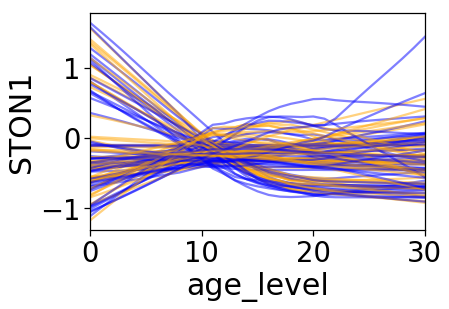

In [104]:
plotr = pandas.DataFrame(gxp.reindex(c1.index).dropna()[-50:],copy=True
                        ).T
scaler = StandardScaler()
plotr = pandas.DataFrame(scaler.fit_transform(plotr.values),
                      index=plotr.index,columns=plotr.columns)
for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period']:
    plotr.loc[:,col] = gdf.loc[:,col]
for i in plotr.columns[:50]:
    g = sns.regplot(x='age_level',y=i,
                      data=plotr[plotr.NT_Segment=='Tele'],
                     color='orange',lowess=True,marker='',
                   line_kws={'alpha':0.5})
    if g.legend_:
        g.legend_.remove()
    g = sns.regplot(x='age_level',y=i,
                      data=plotr[plotr.NT_Segment=='Met'],
                     color='blue',lowess=True,marker='',
                   line_kws={'alpha':0.5})
    if g.legend_:
        g.legend_.remove()
plt.show()

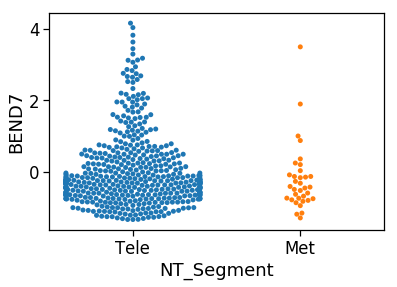

In [66]:
sns.swarmplot('NT_Segment',plotr.columns[4],data=plotr)

In [35]:
c1.shape[0] * 0.025

390.82500000000005

In [ ]:
c1catch = {}

In [37]:
perc = 0.025
thresh = int(round(c1.shape[0] * 0.025))
-thresh

-391

In [53]:
perc = 0.025
thresh = int(round(c1.shape[0] * 0.025))
c1catch = {}
for epoch in plotr.Age_Epoch.unique():
    if not pandas.notnull(epoch): continue
    plotr = pandas.DataFrame(gxp.reindex(c1.gene_symbol
                                        ).dropna().iloc[-thresh:],
                             copy=True).T
    for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
           'Age_Stage', 'Age_Epoch', 'Age_Period']:
        plotr.loc[:,col] = gdf.loc[:,col]
    ts,ps = stats.ttest_ind(plotr[(plotr.NT_Segment=='Tele') &\
                                  (plotr.Age_Epoch==epoch)
                                 ][plotr.columns[:thresh]].values,
                           plotr[(plotr.NT_Segment=='Met') &\
                                 (plotr.Age_Epoch==epoch)
                                ][plotr.columns[:thresh]].values)
    hits = [x for x in range(len(ts)) if ts[x]>0 and ps[x]<0.05]
    
    c1catch.update({'met_%s'%epoch: plotr.columns[hits].tolist()})

    plotr = pandas.DataFrame(gxp.reindex(c1.gene_symbol
                                        ).dropna().iloc[:thresh],
                             copy=True).T
    for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
           'Age_Stage', 'Age_Epoch', 'Age_Period']:
        plotr.loc[:,col] = gdf.loc[:,col]
    ts,ps = stats.ttest_ind(plotr[(plotr.NT_Segment=='Tele') &\
                                  (plotr.Age_Epoch==epoch)
                                 ][plotr.columns[:thresh]].values,
                           plotr[(plotr.NT_Segment=='Met') &\
                                 (plotr.Age_Epoch==epoch)
                                ][plotr.columns[:thresh]].values)
    hits = [x for x in range(len(ts)) if ts[x]<0 and ps[x]<0.05]
    
    c1catch.update({'tele_%s'%epoch: plotr.columns[hits].tolist()})

/home/users/jvogel/gxp/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/users/jvogel/gxp/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/users/jvogel/gxp/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [54]:
c1catch

{'met_e0': ['UNC119B',
  'PSMC3IP',
  'RFX5',
  'ZNF394',
  'WWOX',
  'PNRC1',
  'CEP44',
  'FANCC',
  'LIG1',
  'AIM2'],
 'met_e1': ['TMEM217'],
 'met_e2': ['JAK1'],
 'met_e3': [],
 'tele_e0': ['CTXN3',
  'KLHL29',
  'GALNTL5',
  'SNN',
  'RASL10A',
  'FAT3',
  'TMEM155',
  'SH2D5',
  'CSRNP3',
  'WIF1',
  'DUSP6',
  'PKD2L1',
  'KCNC2',
  'GAST',
  'SERPINI1',
  'ATP2B1',
  'MAST4',
  'RAB3C',
  'TCF7L2',
  'FIGN',
  'SPRN',
  'CRIP2',
  'CTNND2',
  'NETO2',
  'NRAP',
  'PDP1',
  'R3HDM1',
  'ANKRD24',
  'WDR86',
  'PPP1R21',
  'PLXNA1',
  'GABRA5',
  'SATB2'],
 'tele_e1': ['LY86-AS1'],
 'tele_e2': ['PART1', 'C1QL3', 'ANKRD33B', 'VSTM2L', 'TNFAIP6'],
 'tele_e3': ['PART1',
  'RXFP1',
  'THEMIS',
  'TMEM155',
  'PKD2L1',
  'CABP1',
  'CCK',
  'C16orf95',
  'ABCC12',
  'CRYBB1',
  'REP15']}

In [64]:
perc = 0.025
thresh = int(round(c1.shape[0] * 0.025))
c2catch = {}
for epoch in plotr.Age_Epoch.unique():
    if not pandas.notnull(epoch): continue
    plotr = pandas.DataFrame(gxp.reindex(c2.gene_symbol
                                        ).dropna().iloc[-thresh:],
                             copy=True).T
    for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
           'Age_Stage', 'Age_Epoch', 'Age_Period']:
        plotr.loc[:,col] = gdf.loc[:,col]
    Fs,ps = stats.f_oneway(plotr[(plotr.MacroStructure.isin(['Occipital',
                                                              'Parietal',
                                                              'Cerebellum']
                                                           )) &\
                                  (plotr.Age_Epoch==epoch)
                                 ][plotr.columns[:thresh]].values,
                           plotr[(plotr.MacroStructure.isin(['Temporal',
                                                             'Frontal',
                                                             'Sensorimotor',]
                                                           )) &\
                                 (plotr.Age_Epoch==epoch)
                                ][plotr.columns[:thresh]].values,
                          plotr[(plotr.MacroStructure.isin(['Limbic',
                                                            'Thalamus',
                                                            'Striatum']
                                                           )) &\
                                 (plotr.Age_Epoch==epoch)
                                ][plotr.columns[:thresh]].values)
    hits = [x for x in range(len(ts)) if ps[x]<0.05]
    
    c2catch.update({'antvent_%s'%epoch: plotr.columns[hits].tolist()})

    plotr = pandas.DataFrame(gxp.reindex(c2.gene_symbol
                                        ).dropna().iloc[:thresh],
                             copy=True).T
    for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
           'Age_Stage', 'Age_Epoch', 'Age_Period']:
        plotr.loc[:,col] = gdf.loc[:,col]
    Fs,ps = stats.f_oneway(plotr[(plotr.MacroStructure.isin(['Occipital',
                                                              'Parietal',
                                                              'Cerebellum']
                                                           )) &\
                                  (plotr.Age_Epoch==epoch)
                                 ][plotr.columns[:thresh]].values,
                           plotr[(plotr.MacroStructure.isin(['Temporal',
                                                             'Frontal',
                                                             'Sensorimotor',]
                                                           )) &\
                                 (plotr.Age_Epoch==epoch)
                                ][plotr.columns[:thresh]].values,
                          plotr[(plotr.MacroStructure.isin(['Limbic',
                                                            'Thalamus',
                                                            'Striatum']
                                                           )) &\
                                 (plotr.Age_Epoch==epoch)
                                ][plotr.columns[:thresh]].values)
    hits = [x for x in range(len(ts)) if ps[x]<0.05]
    
    c2catch.update({'postdors_%s'%epoch: plotr.columns[hits].tolist()})

/home/users/jvogel/gxp/lib/python3.5/site-packages/scipy/stats/stats.py:3349: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [65]:
c2catch

{'antvent_e0': ['HES4',
  'TEX9',
  'DOK6',
  'SLC8A3',
  'SPHKAP',
  'SLC23A2',
  'LSM7',
  'SGSM1',
  'SLC16A2',
  'PGAP1',
  'PITPNC1',
  'NTSR1',
  'ANKRD50',
  'PCBD1'],
 'antvent_e1': ['CCDC158',
  'RDH10',
  'ACTA1',
  'OPRM1',
  'TRH',
  'WLS',
  'SEMA5A',
  'VAT1L'],
 'antvent_e2': ['NCAN', 'TMEM196'],
 'antvent_e3': [],
 'postdors_e0': ['RTKN2',
  'ATP2B3',
  'TBR1',
  'ADCY9',
  'MIS18BP1',
  'IDS',
  'SLC22A10',
  'ATP2B2',
  'ARHGAP26',
  'TSPAN1',
  'CAMK1D',
  'CNKSR2',
  'NR1D1',
  'NDRG3',
  'RBFOX1',
  'NPTN',
  'HES6',
  'SORL1',
  'HSD17B11',
  'PPP3CA',
  'NCOA3',
  'CACNG6',
  'ROCK2',
  'STXBP1',
  'KCNB1',
  'IPCEF1',
  'CLCN4',
  'PDE1A',
  'MEF2C',
  'DAGLA',
  'PGBD4'],
 'postdors_e1': ['PRSS2', 'SLC16A6', 'MPP7', 'FLRT3', 'MALL', 'KCNA3'],
 'postdors_e2': ['LXN', 'KCNAB3', 'LCE3C', 'RAB12', 'KRT10', 'RNLS', 'VCX2'],
 'postdors_e3': ['COX7A1', 'LCE3C']}

# Gene Tracking Take 2

In [40]:
from sklearn.preprocessing import StandardScaler

perc = 0.025 / 3
thresh = int(round(c1.shape[0] * 0.025))
c1catch = {}

plotr = pandas.DataFrame(gxp.reindex(c1.gene_symbol
                                    ).dropna().iloc[-thresh:],
                         copy=True).T
gcols = plotr.columns
plotr = pandas.DataFrame(StandardScaler().fit_transform(plotr.values),
                 index=plotr.index,columns=gcols)
for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period','new_age_stage',
            'age_in_months','donor_id']:
    plotr.loc[:,col] = gdf.loc[:,col]

gmtx1 = pandas.DataFrame(np.zeros((len(gcols),
                                   len(gdf.new_age_stage.unique()))),
                         index=gcols,
                       columns = gdf.new_age_stage.unique())
for stage in gdf.new_age_stage.unique():
    gmtx1.loc[:,stage] = plotr[plotr.new_age_stage==stage][gcols].mean(0).values
c1catch.update({'met':gmtx1})                        

plotr = pandas.DataFrame(gxp.reindex(c1.gene_symbol
                                    ).dropna().iloc[:thresh],
                         copy=True).T
gcols = plotr.columns
plotr = pandas.DataFrame(StandardScaler().fit_transform(plotr.values),
                 index=plotr.index,columns=gcols)
for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period','new_age_stage',
            'age_in_months','donor_id']:
    plotr.loc[:,col] = gdf.loc[:,col]
gmtx1 = pandas.DataFrame(np.zeros((len(gcols),
                                   len(gdf.new_age_stage.unique()))),
                         index=gcols,
                       columns = gdf.new_age_stage.unique())
for stage in gdf.new_age_stage.unique():
    gmtx1.loc[:,stage] = plotr[plotr.new_age_stage==stage][gcols].mean(0).values
c1catch.update({'tele': gmtx1}) 

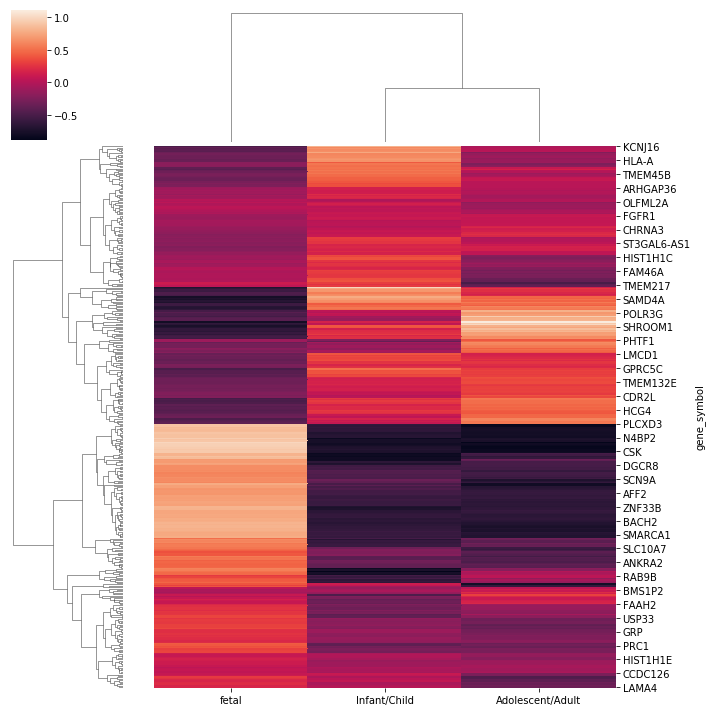

In [21]:
sns.clustermap(c1catch['met'])

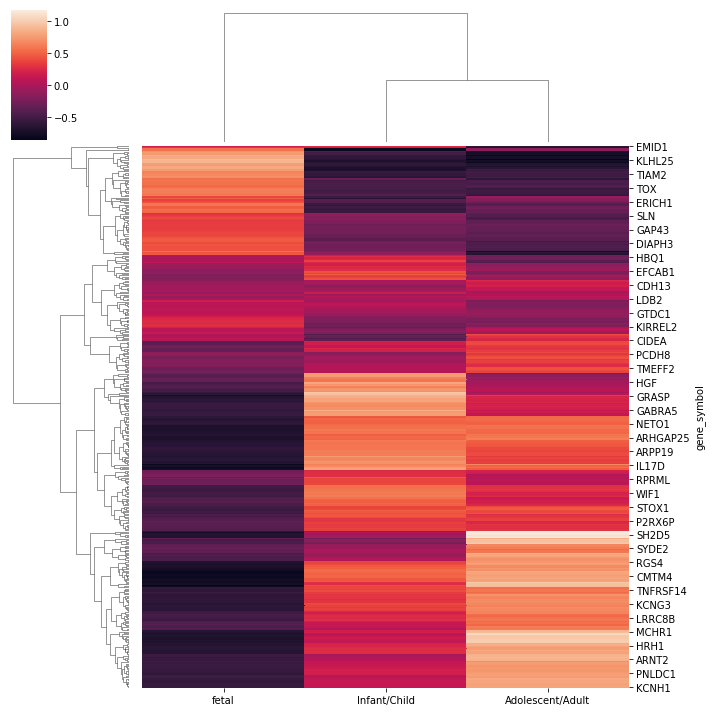

In [22]:
sns.clustermap(c1catch['tele'])

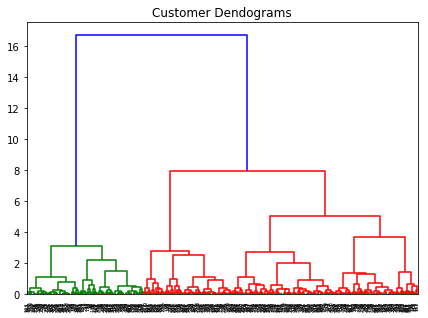

In [35]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(7, 5))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(c1catch['met'], method='ward'))

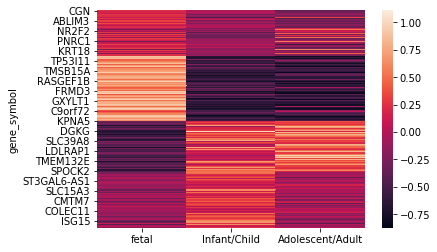

In [34]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(c1catch['met'])
data = pandas.DataFrame(c1catch['met'],copy=True)
data.loc[:,'labels'] = cluster.labels_
sns.heatmap(data.sort_values('labels')[data.columns[:3]])

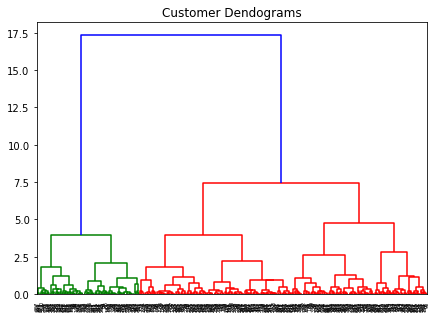

In [36]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(7, 5))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(c1catch['tele'], method='ward'))

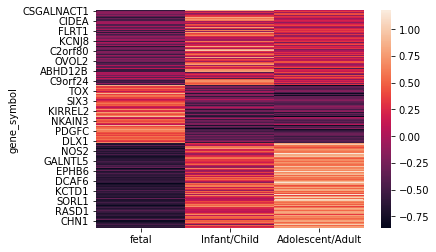

In [37]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(c1catch['tele'])
dataT = pandas.DataFrame(c1catch['tele'],copy=True)
dataT.loc[:,'labels'] = cluster.labels_
sns.heatmap(dataT.sort_values('labels')[dataT.columns[:3]])

In [17]:
# for x in data[data.labels==1].index:
#     print(x)

In [54]:
import statsmodels.formula.api as smf
mod = smf.mixedlm("FOXG1 ~ NT_Segment*age_in_months",
                  data=plotr.dropna(),
                  groups=plotr.dropna()['donor_id'].astype(str)
                 ).fit()
mod.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                    MixedLM       Dependent Variable:       FOXG1    
No. Observations:         523           Method:                   REML     
No. Groups:               42            Scale:                    0.3347   
Min. group size:          1             Log-Likelihood:           -528.5746
Max. group size:          16            Converged:                Yes      
Mean group size:          12.5                                             
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.361    0.178  2.024 0.043  0.012  0.711
NT_Segment[T.Tele]               -0.109    0.130 -0.841 0.400 -0.364  0.145
age_in_months                    -0.003    0.001 -3.226 0.001 -0.005 -0.001
NT_Segment[T.Tele]:age_in_months  0.000    0.001  0.420 0.675 -0.001  0.002
Group Var                         0.483    0.209                           
===========================================================================

"""

In [61]:
jnk = pandas.DataFrame(plotr.dropna(),copy=True)
jnk.loc[:,'predicted'] = mod.predict(plotr.dropna()).values

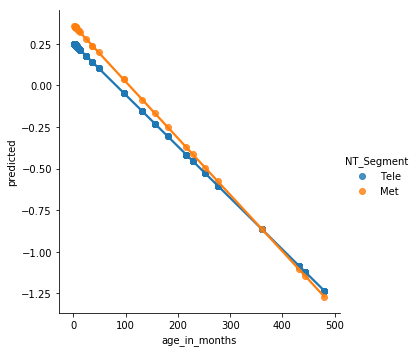

In [63]:
sns.lmplot(x='age_in_months',y='predicted',data=jnk,hue='NT_Segment',
           order=2,
          )

In [52]:
import statsmodels.formula.api as smf
mod = smf.mixedlm("FOXG1 ~ NT_Segment",
                  data=plotr[plotr.new_age_stage=='Fetal'],
                  groups=plotr[plotr.new_age_stage=='Fetal']['donor_id'].astype(str)
                 ).fit()


In [53]:
mod.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM   Dependent Variable:   FOXG1    
No. Observations:   523       Method:               REML     
No. Groups:         42        Scale:                0.3341   
Min. group size:    1         Log-Likelihood:       -522.5259
Max. group size:    16        Converged:            Yes      
Mean group size:    12.5                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.063    0.161  0.391 0.696 -0.252  0.377
NT_Segment[T.Tele] -0.082    0.104 -0.790 0.430 -0.287  0.122
Group Var           0.657    0.275                           
=============================================================

"""

In [28]:
ts,ps = stats.ttest_ind()
    

gene_symbol,FOXG1,TNNT2,CTXN3,ASGR2,PART1,MOXD1,NR2E1,OR14I1,GGTA1P,ABHD12B,...,CHMP4B,INF2,MacroStructure,Sensorifugal,NT_Segment,age_level,Age_Stage,Age_Epoch,Age_Period,new_age_stage
1,0.850049,-0.470655,-0.628023,-0.794277,-0.801160,-0.759523,3.963143,-0.552486,-0.837686,-0.523576,...,0.221765,-0.880627,Somatomotor,Sensory,Tele,0.0,fetal,e0,p2,fetal
2,1.845273,-0.434970,-0.628023,-0.614729,-0.794289,-0.227579,3.757290,-0.552486,-0.859119,-0.519335,...,0.389794,-0.770759,Limbic,Association,Tele,0.0,fetal,e0,p2,fetal
3,0.197744,-0.476038,-0.229920,-0.794277,-0.798260,0.537683,2.148571,-0.552486,-0.879887,-0.523576,...,0.208909,-0.885054,GangEm,Not_Cortex,Tele,0.0,fetal,e0,p2,fetal
4,1.186630,-0.412943,-0.553935,-0.547740,-0.802082,-0.296989,4.721479,-0.552486,-0.995386,-0.487979,...,-0.649996,-0.676017,Temporal,Association,Tele,0.0,fetal,e0,p2,fetal
5,1.437113,-0.300871,-0.575388,-0.794277,-0.779823,0.368746,1.545463,-0.552486,-0.596043,-0.510795,...,0.102763,-0.816114,Cerebellum,Not_Cortex,Met,0.0,fetal,e0,p2,fetal
6,-0.933547,-0.484602,-0.313992,-0.689737,-0.791146,-0.623555,-0.713117,-0.552486,-0.860710,-0.507137,...,0.419668,-1.116553,GangEm,Not_Cortex,Tele,0.0,fetal,e0,p2,fetal
7,1.435642,-0.484602,-0.611541,-0.794277,-0.807876,2.207542,5.042267,-0.552486,-1.026195,-0.519467,...,0.083317,-0.644482,Subcortex,Not_Cortex,Tele,0.0,fetal,e0,p2,fetal
8,-0.930096,-0.476767,-0.381476,-0.592548,-0.814358,-0.485196,0.543255,-0.544457,-0.977243,-0.523576,...,-0.284606,-1.186241,Frontal,Association,Tele,0.0,fetal,e0,p2,fetal
9,0.504818,-0.431511,-0.607184,-0.794277,-0.789523,-0.697200,3.724652,-0.552486,-0.858729,-0.518469,...,1.440229,-1.044311,Frontal,Association,Tele,0.0,fetal,e0,p2,fetal
10,0.230334,-0.427263,-0.628023,-0.794277,-0.796436,-0.021842,3.160980,-0.552486,-0.759068,-0.506534,...,1.094942,-1.026125,Frontal,Association,Tele,0.0,fetal,e0,p2,fetal


In [16]:
### See frequency of different genes in top genes 
### compared to the whole gene list

from sklearn.preprocessing import StandardScaler

perc = 0.025 / 3
thresh = int(round(c1.shape[0] * 0.025))
c1catch = {}

plotr = pandas.DataFrame(gxp.reindex(c1.gene_symbol
                                    ).dropna().iloc[-thresh:],
                         copy=True).T
gcols = plotr.columns
plotr = pandas.DataFrame(StandardScaler().fit_transform(plotr.values),
                 index=plotr.index,columns=gcols)
for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period','new_age_stage']:
    plotr.loc[:,col] = gdf.loc[:,col]

gmtx1 = pandas.DataFrame(np.zeros((len(gcols),
                                   len(gdf.new_age_stage.unique()))),
                         index=gcols,
                       columns = gdf.new_age_stage.unique())
for stage in gdf.new_age_stage.unique():
    gmtx1.loc[:,stage] = plotr[plotr.new_age_stage==stage][gcols].mean(0).values
c1catch.update({'met':gmtx1})                        

plotr = pandas.DataFrame(gxp.reindex(c1.gene_symbol
                                    ).dropna().iloc[:thresh],
                         copy=True).T
gcols = plotr.columns
plotr = pandas.DataFrame(StandardScaler().fit_transform(plotr.values),
                 index=plotr.index,columns=gcols)
for col in ['MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period','new_age_stage']:
    plotr.loc[:,col] = gdf.loc[:,col]
gmtx1 = pandas.DataFrame(np.zeros((len(gcols),
                                   len(gdf.new_age_stage.unique()))),
                         index=gcols,
                       columns = gdf.new_age_stage.unique())
for stage in gdf.new_age_stage.unique():
    gmtx1.loc[:,stage] = plotr[plotr.new_age_stage==stage][gcols].mean(0).values
c1catch.update({'tele': gmtx1}) 

# AHBA Comparison

Text(0, 0.5, 'C1 Pattern Expression')

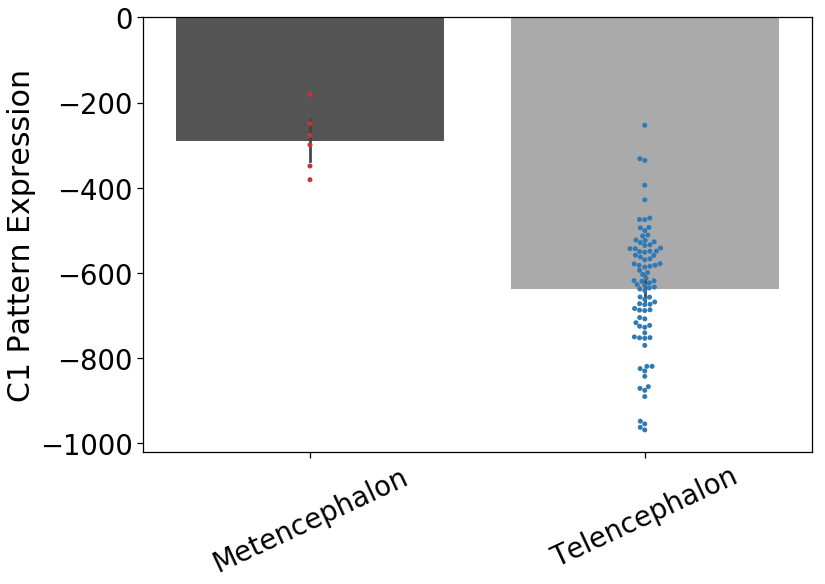

In [68]:
# Just cortex and cerebellum
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Met','Tele']
sns.barplot(x='NT_Segment', y='C1_exp', 
            data=gdf[gdf.Age_Stage=='adult'],
            palette='gray',
           order = order
           )
g=sns.swarmplot(x='NT_Segment', y='C1_exp', 
              data=gdf[gdf.Age_Stage=='adult'], 
              #hue='brain_divison',
              order = order, palette=rbpal)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Metencephalon','Telencephalon'],rotation=25)
plt.xlabel('')
plt.ylabel('C1 Pattern Expression')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_BS_C1.pdf',
#            bbox_inches='tight')

Text(0, 0.5, 'C1 Pattern Expression')

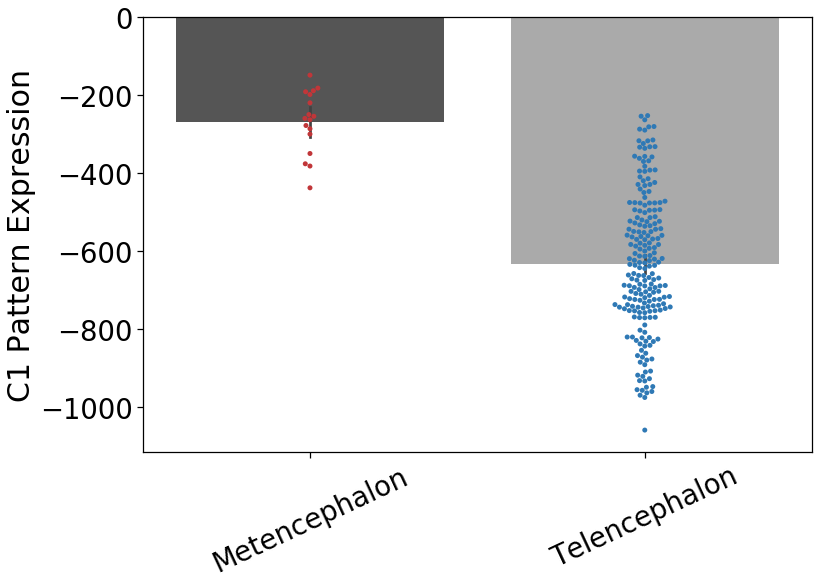

In [69]:
# Just cortex and cerebellum
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Met','Tele']
sns.barplot(x='NT_Segment', y='C1_exp', 
            data=gdf[gdf.Age_Stage.isin(['adult',
                                         'adolescent',
                                         'child'])],
            palette='gray',
           order = order
           )
g=sns.swarmplot(x='NT_Segment', y='C1_exp', 
              data=gdf[gdf.Age_Stage.isin(['adult',
                                         'adolescent',
                                         'child'])],
              #hue='brain_divison',
              order = order, palette=rbpal)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Metencephalon','Telencephalon'],rotation=25)
plt.xlabel('')
plt.ylabel('C1 Pattern Expression')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_BS_C1-2.pdf',
#            bbox_inches='tight')

In [86]:
abac2 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_BSComp_ABA_C2_data.csv',
                       index_col=0)
abac2.columns = ['ABA_mean','ABA_sem']
print('shared:',set(abac2.index) & set(gdf.MacroStructure2.unique()))
print('missing:',set(gdf.MacroStructure2.unique()) - set(abac2.index))

shared: {'Limbic', 'Thalamus', 'Sensorimotor', 'Parietal', 'Cerebellum', 'Striatum', 'Frontal', 'Occipital', 'Temporal'}
missing: {'GangEm'}


In [87]:
bsc2 = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='C2_exp',
                             index='MacroStructure2',aggfunc=np.mean
                            )
for div in bsc2.index:
    sem = gdf[gdf.MacroStructure2==div]['C2_exp'].sem()
    bsc2.loc[div,'sem'] = sem
bsc2.columns = ['BS_mean','BS_sem']

In [88]:
c2_comp = pandas.concat([bsc2,abac2],axis=1,sort='True').dropna()
c2_comp.loc[:,'region'] = c2_comp.index
c2_comp.head()

,BS_mean,BS_sem,ABA_mean,ABA_sem,region
Cerebellum,37.205073,23.029420,-0.243192,0.002716,Cerebellum
Frontal,81.935791,11.113875,-0.137349,0.004142,Frontal
Limbic,148.054347,12.778033,0.088853,0.007918,Limbic
Occipital,7.508905,27.336295,-0.406508,0.006777,Occipital
Parietal,37.597848,23.250301,-0.304801,0.006000,Parietal


Text(14.920000000000002, 0.5, 'C2: BrainSpan')

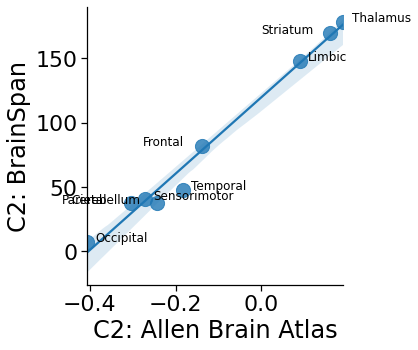

In [29]:
sns.set_context('notebook',font_scale=2)
sns.lmplot(x='ABA_mean',y='BS_mean',data=c2_comp,
           scatter_kws={'marker':'o','s':200}
           #hue='region',legend=False,fit_reg=False
          )
for i,div in enumerate(c2_comp.sort_values('ABA_mean').index):
    x = c2_comp.loc[div,'ABA_mean']
    #xsem = c2_comp.loc[div,'ABA_sem']
    y = c2_comp.loc[div,'BS_mean']
    #ysem = c2_comp.loc[div,'BS_sem']
    dist = len(div)*.02
    if i%2==0:
        plt.text(x+.02, y,div,{'size':12})
    else:
        plt.text(x-dist, y,div,{'size':12},
                 )
#     plt.plot([x-xsem,x+xsem],[y,y],c='k')
#     plt.plot([x,x],[y-ysem,y+ysem],c='k')
plt.xlabel('C2: Allen Brain Atlas')
plt.ylabel('C2: BrainSpan')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_C2.pdf',
#            bbox_inches='tight')

In [78]:
252 / 12

21.0

r = 0.93, p = 0.0


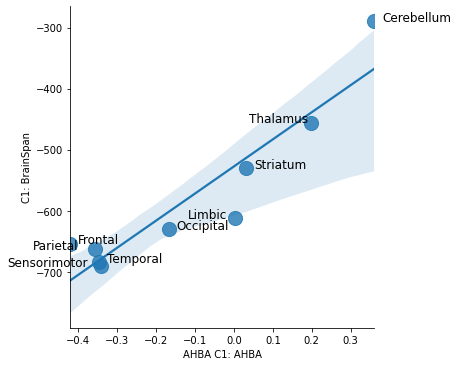

r = 0.975, p = 0.0


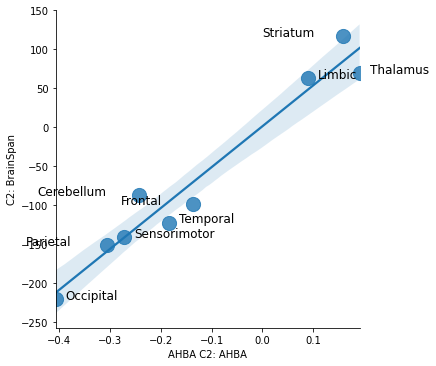

r = 0.856, p = 0.003


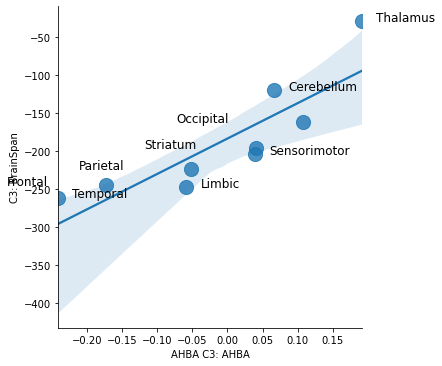

In [90]:
for i in range(1,4):
    aba = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_BSComp_ABA_C%s_data.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    bs = pandas.pivot_table(#gdf,
                            gdf[gdf.Age_Stage=='adult'],
                          values='C%s_exp'%i,
                             index='MacroStructure2',aggfunc=np.mean
                            )
    for div in bs.index:
        sem = gdf[gdf.MacroStructure2==div]['C%s_exp'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['BS_mean','BS_sem']
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = c2_comp.index
    
    sns.lmplot(x='ABA_mean',y='BS_mean',data=comp,
           scatter_kws={'marker':'o','s':200}
           #hue='region',legend=False,fit_reg=False
          )
    r,p = stats.pearsonr(comp.ABA_mean.values,comp.BS_mean.values)
    print('r = %s, p = %s'%(round(r,3),round(p,3)))
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        #xsem = c2_comp.loc[div,'ABA_sem']
        y = comp.loc[div,'BS_mean']
        #ysem = c2_comp.loc[div,'BS_sem']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x+.02, y,div,{'size':12})
        else:
            plt.text(x-dist, y,div,{'size':12},
                     )
    #     plt.plot([x-xsem,x+xsem],[y,y],c='k')
    #     plt.plot([x,x],[y-ysem,y+ysem],c='k')
    plt.xlabel('AHBA C%s: AHBA'%i)
    plt.ylabel('C%s: BrainSpan'%i)
    plt.show()

In [104]:
gdf.columns

Index(['column_num', 'donor_id', 'donor_name', 'age', 'gender', 'structure_id',
       'structure_acronym', 'structure_name', 'C1_exp', 'C2_exp', 'C3_exp',
       'MacroStructure', 'Sensorifugal', 'NT_Segment', 'age_level',
       'Age_Stage', 'Age_Epoch', 'Age_Period', 'MacroStructure2'],
      dtype='object')

In [77]:
jnk = sns.color_palette('tab10')
c3pal = [jnk[1],jnk[0],jnk[2]]
#sns.palplot(c3pal)

Text(0, 0.5, 'C3 Pattern Expression')

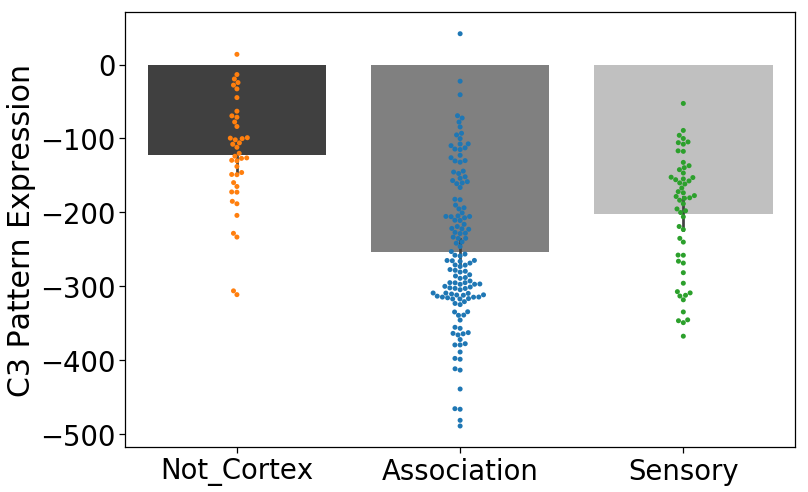

In [78]:
# Just cortex and cerebellum
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not_Cortex','Association','Sensory']
sns.barplot(x='Sensorifugal', y='C3_exp', 
            data=gdf[gdf.Age_Stage.isin(['adult',
                                         'adolescent',
                                         'child'])],
            palette='gray',
           order = order
           )
g=sns.swarmplot(x='Sensorifugal', y='C3_exp', 
              data=gdf[gdf.Age_Stage.isin(['adult',
                                         'adolescent',
                                         'child'])],
              #hue='brain_divison',palette='RdBu'
              order = order, palette=c3pal
               )
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#g.set_xticklabels(['Metencephalon','Telencephalon'],rotation=25)
plt.xlabel('')
plt.ylabel('C3 Pattern Expression')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/BSComp_BS_C3.pdf',
#            bbox_inches='tight')

#### Individual subject matching

In [108]:
gpdfs = {}
for i in range(1,4):
    gpdf = gdf[['donor_id','C%s_exp'%i,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values='C%s_exp'%i)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [10]:
print(gpdfs[1].shape)
gpdfs[1].head()

(42, 10)


MacroStructure2,Cerebellum,Frontal,Limbic,Occipital,Parietal,Sensorimotor,Striatum,Temporal,Thalamus,n_valid
donor_id,,,,,,,,,,
12287,NaN,-545.172436,NaN,-493.855110,-456.335361,NaN,-388.092673,-478.203509,-493.617956,6.0
12288,-399.661932,-492.390176,-438.499461,-449.586169,-525.764310,-522.928714,-459.299208,-515.985532,-591.163242,9.0
12289,-147.928049,-783.805982,-679.350184,-611.712731,-709.495107,-747.751473,NaN,-793.789026,NaN,7.0
12290,-299.067366,-799.082790,-703.342776,-723.127877,-875.604639,-824.728064,-598.847106,-838.272756,-617.932096,9.0
12295,-245.070779,-574.048062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [11]:
gpdfs[1].n_valid.value_counts()

9.0    18
8.0     9
7.0     6
6.0     3
4.0     2
2.0     2
3.0     1
1.0     1
Name: n_valid, dtype: int64

In [109]:
for c in range(1,4):
    cdf = gpdfs[c]
    aba = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_BSComp_ABA_C%s_data.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-1]]
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 5:
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [110]:
cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level', 'new_age_gp', 'new_age_stage','age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']

In [111]:
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().values
for c in range(1,4):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

In [ ]:
g.ax.transAxes

r=0.757, p=0.0


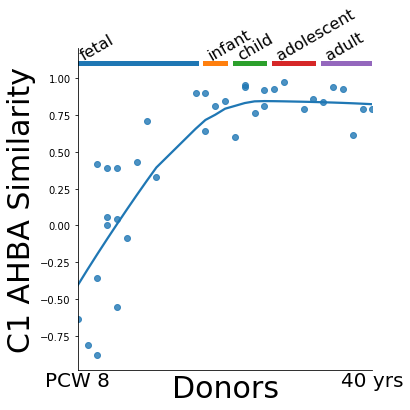

r=0.138, p=0.4227


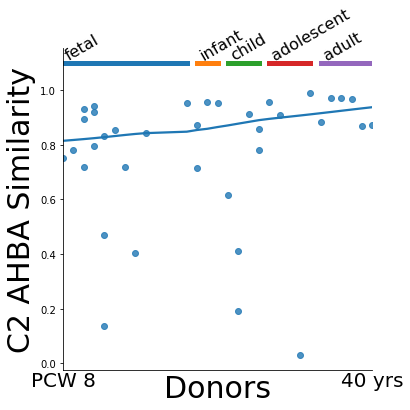

r=0.775, p=0.0


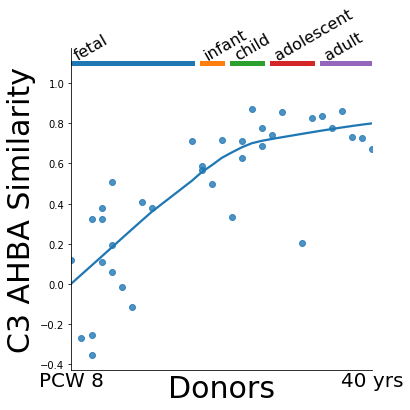

In [99]:
for c in range(1,4):
    g=sns.lmplot(x='age_level',y='C%s_r'%c,
                #hue='SEX',
                lowess=True,
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'age_level']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.age_level.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    g.set_xticklabels(rotation=90)
    g.set_xticklabels(rotation=90)
    for stage in gdf.Age_Stage.unique():
        levels = gdf[gdf.Age_Stage==stage]['age_level'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    plt.ylabel('C%s AHBA Similarity'%c,fontsize=30)
    # plt.yticks([])
    plt.xlabel('Donors',fontsize=30)
    plt.xticks([])
    ymin = subsum['C%s_r'%c].min() - 0.1
    plt.text(0,-0.05,'PCW 8',fontsize=20,ha='center',
         transform=g.ax.transAxes)
    plt.text(1,-0.05,'40 yrs',fontsize=20,ha='center',
             transform=g.ax.transAxes)
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/BrSp_CompR_C%s.pdf'%c,
#                bbox_inches='tight')
    plt.show()
    
#     # rho
#     g=sns.lmplot(x='age_level',y='C%s_rho'%c,
#                 #hue='SEX',
#                 lowess=True,
#                data=subsum)
#     plotr = pandas.DataFrame(subsum[['C%s_rho'%c,'age_level']],
#                             copy=True).dropna()
#     r,p=stats.pearsonr(plotr['C%s_rho'%c].values,
#                       plotr.age_level.values)
#     print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
#     g.set_xticklabels(rotation=90)
#     g.set_xticklabels(rotation=90)
#     for stage in gdf.Age_Stage.unique():
#         levels = gdf[gdf.Age_Stage==stage]['age_level'].values
#         xmin = np.min(levels)
#         xmax = np.max(levels)
#         plt.plot([xmin,xmax],[1.1,1.1],lw=5)
#         #loc = xmin + (xmax-xmin)*.5
#         plt.text(xmin,1.1,stage,fontsize=16,ha='left',
#                  va='bottom',rotation=30)
#     plt.ylabel('C%s Expression'%c,fontsize=30)
#     # plt.yticks([])
#     plt.xlabel('Donors',fontsize=30)
#     plt.xticks([])
#     ymin = subsum['C%s_r'%c].min() - 0.1
#     plt.text(0,-0.05,'PCW 8',fontsize=20,ha='center',
#          transform=g.ax.transAxes)
#     plt.text(1,-0.05,'40 yrs',fontsize=20,ha='center',
#              transform=g.ax.transAxes)
#     plt.show()


In [117]:
devplot = pandas.DataFrame(pandas.concat([subsum.C1_r,
                                          subsum.C2_r,
                                          subsum.C3_r]))
devplot.columns = ['r']
n = len(subsum)
devplot.loc[:,'Component'] = [1]*n + [2]*n + [3]*n
devplot.loc[:,'age_level'] = subsum.age_level.tolist() * 3
devplot.loc[:,'age_in_months'] = subsum.age_in_months.tolist() * 3
devplot.loc[:,'log_age_months'] = subsum.log_age_months.tolist() * 3
devplot.loc[:,'age_in_weeks'] = subsum.age_in_weeks.tolist() * 3
devplot.loc[:,'log_age_weeks'] = subsum.log_age_weeks.tolist() * 3

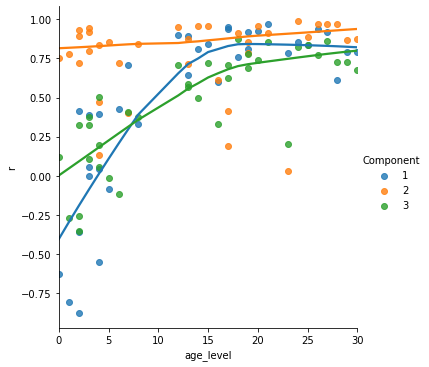

In [87]:
g=sns.lmplot(x='age_level',y='r',hue='Component',lowess=True,
               data=devplot)
plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/BrSp_CompR_labels.pdf',
           bbox_inches='tight')

In [ ]:
g.ax.set_ylim

Text(0.5, 6.79999999999999, 'log Age (weeks)')

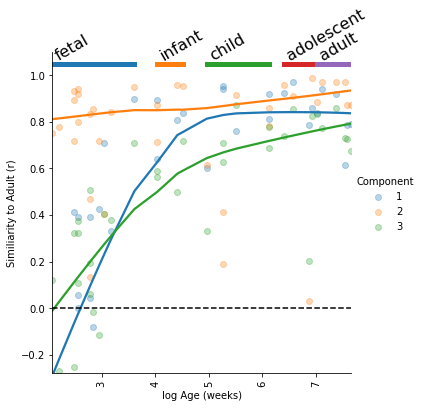

In [118]:
g=sns.lmplot(x='log_age_weeks',y='r',hue='Component',lowess=True,aspect=1,
               data=devplot,scatter_kws={'alpha':0.3})
g.ax.set_ylim(-0.3,1.08)
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,ls='--',c='k')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (weeks)')
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/BrSp_CompR_overlay.pdf',
#            bbox_inches='tight')

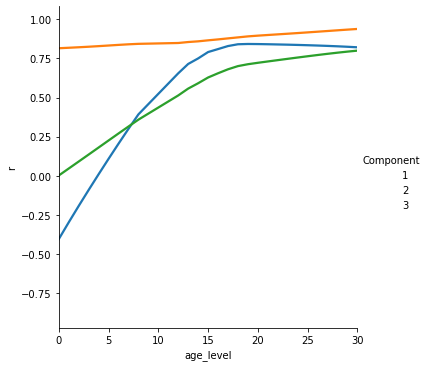

In [51]:
g=sns.lmplot(x='age_level',y='r',hue='Component',lowess=True,
               data=devplot,markers='')
plt.show()

r=0.775, p=0.0


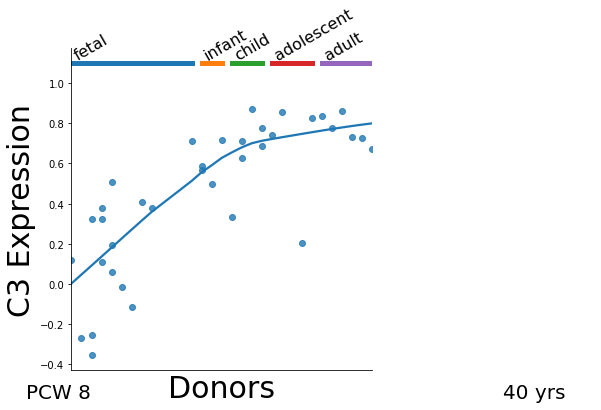

In [39]:
sns.lmplot(x='age_level',y='C%s_r'%c,
            #hue='SEX',
            lowess=True,
           data=subsum)
plotr = pandas.DataFrame(subsum[['C%s_r'%c,'age_level']],
                        copy=True).dropna()
r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                  plotr.age_level.values)
print('r=%s, p=%s'%(round(r,3),round(p,4)))

g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['age_level'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.1,1.1],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.1,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C%s Expression'%c,fontsize=30)
# plt.yticks([])
plt.xlabel('Donors',fontsize=30)
plt.xticks([])
ymin = subsum['C%s_r'%c].min() - 0.1
plt.text(0,-0.05,'PCW 8',fontsize=20,ha='center',
         transform=g.ax.transAxes)
plt.text(1,-0.05,'40 yrs',fontsize=20,ha='center',
         transform=g.ax.transAxes)
plt.show()

#### Comparison to GTex

In [119]:
gss = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GTEx_IndivCongruence.csv',
                     index_col=0)

In [122]:
d1 = pandas.DataFrame(gss[['AGE','SEX','C1_r','C2_r','C3_r','n_valid']],
                      copy=True)
d1.columns = ['age','sex','C1_r','C2_r','C3_r','nvalid']
d1.loc[:,'cohort'] = 'GTEx'
d1.loc[:,'age_in_months'] = d1.loc[:,'age'] * 12
d1.loc[:,'age_in_weeks'] = d1.loc[:,'age'] * 52

d2 = pandas.DataFrame(subsum[['age','gender','C1_r','C2_r',
                              'C3_r','n_valid','age_in_months','age_in_weeks']],
                     copy=True)
d2.columns = ['age','sex','C1_r','C2_r','C3_r','nvalid','age_in_months','age_in_weeks']
d2.loc[:,'cohort'] = 'BrainSpan'

dsmerge = pandas.concat([d1,d2])

In [123]:
dsmerge

,age,sex,C1_r,C2_r,C3_r,nvalid,cohort,age_in_months,age_in_weeks
0,66,2,NaN,NaN,NaN,1.0,GTEx,792.000000,3432.000
1,61,1,NaN,NaN,NaN,2.0,GTEx,732.000000,3172.000
2,66,2,NaN,NaN,NaN,2.0,GTEx,792.000000,3432.000
3,64,1,NaN,NaN,NaN,2.0,GTEx,768.000000,3328.000
4,55,1,0.907067,0.950004,0.755279,6.0,GTEx,660.000000,2860.000
...,...,...,...,...,...,...,...,...,...
37,18 yrs,M,0.785420,0.029569,0.204272,7.0,BrainSpan,216.000000,975.105
38,21 yrs,F,0.837416,0.884872,0.833821,9.0,BrainSpan,252.000000,1131.105
39,8 pcw,M,-0.630225,0.752546,0.121361,8.0,BrainSpan,1.839080,8.000
40,12 pcw,F,-0.358615,0.718063,-0.254023,9.0,BrainSpan,2.758621,12.000


In [95]:
# for i,row in dsmerge.iterrows():
#     if row['cohort'] == 'GTEx':
#         dsmerge.loc[i,'age'] = dsmerge.loc[i,'age'] * 52

In [124]:
dsmerge.loc[:,'logAge'] = np.log(dsmerge.loc[:,'age_in_weeks'].values)

In [125]:
dsmerge.loc[:,'old_ind'] = dsmerge.index
dsmerge.index = range(len(dsmerge))

In [126]:
for i,row in dsmerge.iterrows():
    age = row['age_in_months'] / 12
    if age < 0.72:
        decade = 0
    elif age < 2:
        decade = 0.1
    elif age < 9:
        decade = 0.5
    else:
        decade = round(age/10)
    dsmerge.loc[i,'decade'] = decade

In [127]:
ages = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].logAge.tolist() * 3)
rs = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].C1_r.tolist() +\
                   dsmerge[dsmerge.cohort=='GTEx'].C2_r.tolist() +\
                   dsmerge[dsmerge.cohort=='GTEx'].C3_r.tolist())
n = len(dsmerge[dsmerge.cohort=='GTEx'])
comp = pandas.Series(['C1']*n + ['C2']*n + ['C3']*n)
decade = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].decade.tolist() * 3)
gtplotr = pandas.concat([ages,rs,comp,decade],axis=1)
gtplotr.columns = ['logAge','r','component','decade']


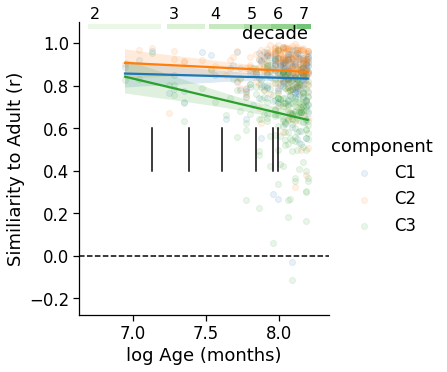

In [130]:
sns.set_context('notebook',font_scale=1.5)
pal = sns.color_palette('Greens',len(dsmerge.decade.unique()))
sns.lmplot(x='logAge',y='r',hue='component',data=gtplotr,
          scatter_kws={'alpha':0.1})
plt.axhline(0,ls='--',c='k')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (months)')
for i,dec in enumerate(sorted(gtplotr.decade.unique())):
    if dec == 8: continue
    levels = dsmerge[dsmerge.decade==dec]['logAge'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.08,1.08],lw=5,c=pal[i])
    #loc = xmin + (xmax-xmin)*.5
    if dec >= 1:
        lab = int(dec)
    else:
        lab = dec
    plt.text(xmin,1.1,lab,fontsize=16,ha='left',
             va='bottom',rotation=0)
plt.text(xmax,1,'decade',ha='right',va='bottom')
allen_ages = [57,31,49,55,24,39]
for aa in allen_ages:
    la = np.log((aa*52))
    plt.plot([la,la],[0.4,0.6],c='k')
# plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/GTEx_logAge.pdf',
#            bbox_inches='tight')

In [81]:
dsmerge.to_csv('BrainSpan_GTEx_PLSC_similarity.csv')

In [47]:
dsmerge.loc[:,'ind'] = dsmerge.index
comp_cols = ['C1_r','C2_r','C3_r']
tall = pandas.melt(dsmerge,id_vars='ind',value_vars=comp_cols)
tall.columns = ['ind','component','exp']
for col in ['age','sex','nvalid','cohort','age_in_months','logAge','decade']:
    tall.loc[:,col] = dsmerge[col].tolist() * len(comp_cols)

In [53]:
tall.dropna().to_csv("Lifespan_Components_tall_nonan.csv",index=False)

<AxesSubplot:xlabel='logAge', ylabel='C3_r'>

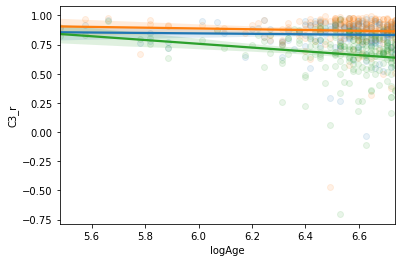

In [26]:
sns.regplot(x='logAge',y='C1_r',data=dsmerge[dsmerge.cohort=='GTEx'],
           #lowess=True,
            scatter_kws={'alpha':0.1})#marker='')
sns.regplot(x='logAge',y='C2_r',data=dsmerge[dsmerge.cohort=='GTEx'],
           #lowess=True,
            scatter_kws={'alpha':0.1})#marker='')
sns.regplot(x='logAge',y='C3_r',data=dsmerge[dsmerge.cohort=='GTEx'],
           #lowess=True,
            scatter_kws={'alpha':0.1})#marker='')


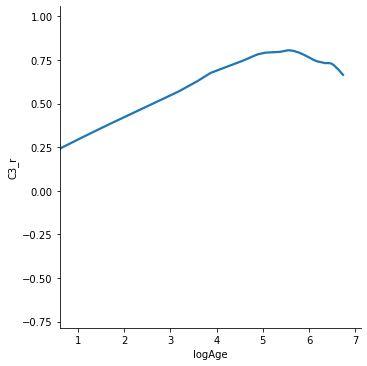

In [92]:
sns.lmplot(x='logAge',y='C3_r',lowess=True,data=dsmerge,
          markers='')

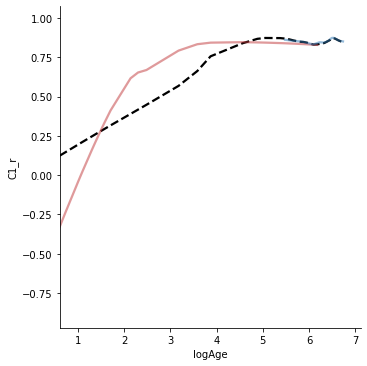

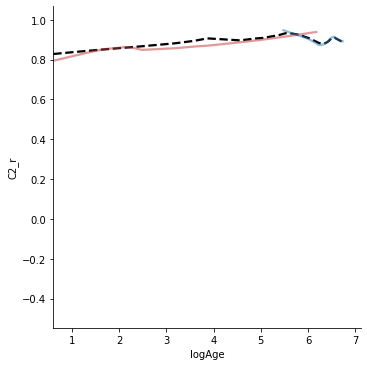

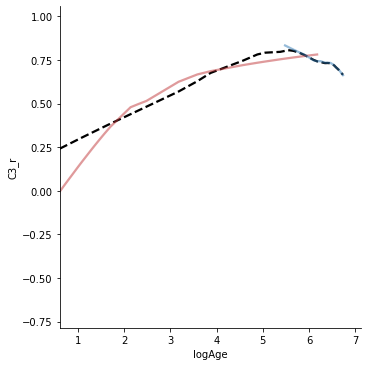

In [135]:
for c in range(1,4):
    sns.lmplot(x='logAge',y='C%s_r'%c,lowess=True,data=dsmerge,
              markers='',line_kws={'color':'black','ls':'--'})
    sns.regplot(x='logAge',y='C%s_r'%c,lowess=True,marker='',
                data=dsmerge[dsmerge.cohort=='BrainSpan'],color=rbpal[0],
               line_kws={'alpha':0.5})
    sns.regplot(x='logAge',y='C%s_r'%c,
                lowess=True,line_kws={'alpha':0.5},
                marker='',
                data=dsmerge[dsmerge.cohort=='GTEx'],color=rbpal[1])
    

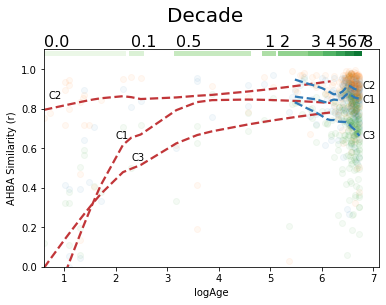

In [233]:
pal = sns.color_palette('Greens',len(dsmerge.decade.unique()))
for c in range(1,4):
    sns.regplot(x='logAge',y='C%s_r'%c,lowess=True,data=dsmerge,
              #marker='',
                #line_kws={'color':'black',
                          #'ls':'--'
                 #        },
                fit_reg=False,
               scatter_kws={'alpha':0.05})
    sns.regplot(x='logAge',y='C%s_r'%c,lowess=True,marker='',
                line_kws={'ls':'--',
                         # 'alpha':0.5
                         },
                data=dsmerge[dsmerge.cohort=='BrainSpan'],color=rbpal[0])
    sns.regplot(x='logAge',y='C%s_r'%c,lowess=True,marker='',
                line_kws={
                    #'color':'black',
                    'ls':'--',
                #    'alpha':0.5
                },
                data=dsmerge[dsmerge.cohort=='GTEx'],color=rbpal[1])
for i,dec in enumerate(sorted(dsmerge.decade.unique())):
    levels = dsmerge[dsmerge.decade==dec]['logAge'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.08,1.08],lw=5,c=pal[i])
    #loc = xmin + (xmax-xmin)*.5
    if dec >= 1:
        lab = int(dec)
    else:
        lab = dec
    plt.text(xmin,1.1,lab,fontsize=16,ha='left',
             va='bottom',rotation=0)
plt.text(3,1.24,'Decade',size=20)
plt.ylim(0,1.1)
plt.ylabel('AHBA Similarity (r)')
plt.text(0.7,0.85,'C2')
plt.text(2,0.65,'C1')
plt.text(2.3,0.54,'C3')
plt.text(6.8,0.9,'C2')
plt.text(6.8,0.83,'C1')
plt.text(6.8,0.65,'C3')
plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/Lifespan_R.pdf',
           bbox_inches='tight')

In [225]:
dsmerge[dsmerge.decade==2]

,age,sex,C1_r,C2_r,C3_r,nvalid,cohort,age_in_months,logAge,old_ind,decade
31,23,1,NaN,NaN,NaN,2.0,GTEx,276.0,5.620401,31,2.0
38,25,1,NaN,NaN,NaN,5.0,GTEx,300.0,5.703782,38,2.0
333,22,1,0.919633,0.968810,0.831174,8.0,GTEx,264.0,5.575949,333,2.0
339,24,2,0.960537,0.978389,0.952162,6.0,GTEx,288.0,5.662960,339,2.0
344,20,1,0.888940,0.900499,0.826240,9.0,GTEx,240.0,5.480639,344,2.0
383,15 yrs,M,NaN,NaN,NaN,4.0,BrainSpan,180.0,5.192957,7,2.0
384,23 yrs,M,0.939254,0.970432,0.774490,8.0,BrainSpan,276.0,5.620401,8,2.0
392,19 yrs,F,0.857798,0.988319,0.823716,9.0,BrainSpan,228.0,5.429346,16,2.0
413,18 yrs,M,0.785420,0.029569,0.204272,7.0,BrainSpan,216.0,5.375278,37,2.0
414,21 yrs,F,0.837416,0.884872,0.833821,9.0,BrainSpan,252.0,5.529429,38,2.0


In [164]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy=0.5)
ind = dsmerge[['C1_r','C2_r','C3_r','logAge']].dropna().index
X = dsmerge.loc[ind]
print(X.shape)
y = dsmerge.loc[ind,'cohort']
uX,uy = under.fit_resample(X,y)
print(uX.shape)

(302, 10)
(162, 10)


(0.0, 1.1)

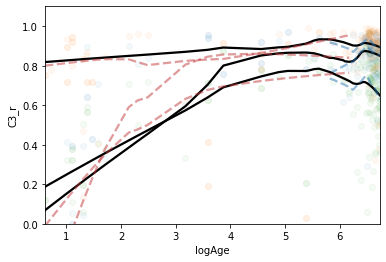

In [165]:
for c in range(1,4):
    sns.regplot(x='logAge',y='C%s_r'%c,lowess=True,data=uX,
              #marker='',
                line_kws={'color':'black',
                          #'ls':'--'
                         },
               scatter_kws={'alpha':0.05})
    sns.regplot(x='logAge',y='C%s_r'%c,lowess=True,marker='',
                line_kws={'ls':'--','alpha':0.5},
                data=uX[uX.cohort=='BrainSpan'],color=rbpal[0])
    sns.regplot(x='logAge',y='C%s_r'%c,lowess=True,marker='',
                line_kws={
                    #'color':'black',
                    'ls':'--','alpha':0.5},
                data=uX[uX.cohort=='GTEx'],color=rbpal[1])
plt.ylim(0,1.1)

In [158]:
pandas.Series(uy).value_counts()

GTEx         108
BrainSpan     54
Name: cohort, dtype: int64

In [154]:
under

RandomUnderSampler(sampling_strategy=0.5)

In [151]:
X.dropna().shape

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

(0.0, 1.1)

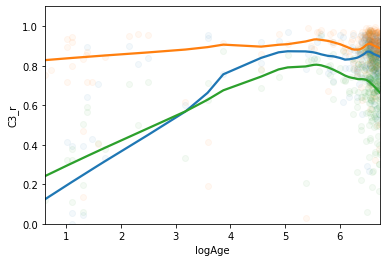

In [141]:
for c in range(1,4):
    sns.regplot(x='logAge',y='C%s_r'%c,lowess=True,data=dsmerge,
              #marker='',#line_kws={'color':'black','ls':'--'}
               scatter_kws={'alpha':0.05})
plt.ylim(0,1.1)

In [132]:
for i,row in dsmerge.iterrows():
    age = row['age_in_months'] / 12
    if age < 0.72:
        decade = 0
    elif age < 2:
        decade = 0.1
    elif age < 9:
        decade = 0.5
    else:
        decade = round(age/10)
    dsmerge.loc[i,'decade'] = decade

[Text(0, 0, '16 pcw'),
 Text(1, 0, '24 pcw'),
 Text(2, 0, '11 yrs'),
 Text(3, 0, '30 yrs'),
 Text(4, 0, '35 pcw'),
 Text(5, 0, '4 mos'),
 Text(6, 0, '4 yrs'),
 Text(7, 0, '15 yrs'),
 Text(8, 0, '23 yrs'),
 Text(9, 0, '36 yrs'),
 Text(10, 0, '37 yrs'),
 Text(11, 0, '40 yrs'),
 Text(12, 0, '21 pcw'),
 Text(13, 0, '13 pcw'),
 Text(14, 0, '1 yrs'),
 Text(15, 0, '13 yrs'),
 Text(16, 0, '19 yrs'),
 Text(17, 0, '9 pcw'),
 Text(18, 0, '12 pcw'),
 Text(19, 0, '3 yrs'),
 Text(20, 0, '8 yrs'),
 Text(21, 0, '17 pcw'),
 Text(22, 0, '19 pcw'),
 Text(23, 0, '25 pcw'),
 Text(24, 0, '26 pcw'),
 Text(25, 0, '10 mos'),
 Text(26, 0, '2 yrs'),
 Text(27, 0, '18 yrs'),
 Text(28, 0, '21 yrs'),
 Text(29, 0, '8 pcw'),
 Text(30, 0, '37 pcw')]

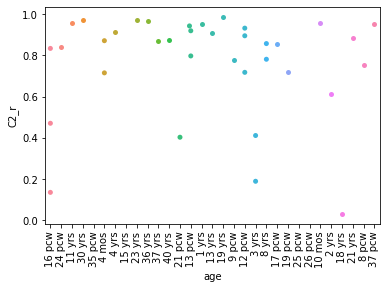

In [131]:
# g=sns.swarmplot(x='age',y='C2_r',data=dsmerge[dsmerge.cohort=='BrainSpan'])
# g.set_xticklabels(g.get_xticklabels(),rotation=90)

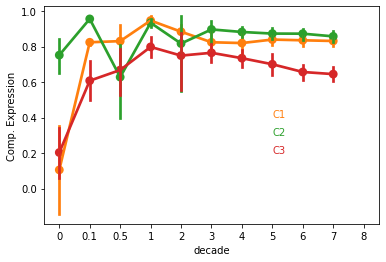

In [235]:
for c in range(1,4):
    g=sns.pointplot(x='decade',y='C%s_r'%c,lowess=True,data=dsmerge,
                  color=sns.color_palette('tab10')[c])
g.set_xticklabels([0,0.1,0.5,1,2,3,4,5,6,7,8])
g.set_ylabel('Comp. Expression')
plt.text(7,0.4,'C1',c=sns.color_palette('tab10')[1])
plt.text(7,0.3,'C2',c=sns.color_palette('tab10')[2])
plt.text(7,0.2,'C3',c=sns.color_palette('tab10')[3])
plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/Lifespan_R_decade.pdf',
           bbox_inches='tight')

# Save for Bratislav's group

#### harmonized version

In [16]:
gxp.shape

(18503, 524)

In [17]:
rmd.shape

(47384, 5)

In [18]:
gxp.head()

,1,2,3,4,5,6,7,8,9,10,...,515,516,517,518,519,520,521,522,523,524
TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,44.943915,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
TNMD,0.044081,0.067338,0.000000,0.145466,0.185188,0.311180,0.000000,0.000000,0.473831,0.181220,...,0.758571,0.000000,0.061869,0.026876,0.100691,0.140675,0.300576,0.126526,0.000000,0.424134
DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,38.157569,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,3.609830,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,3.560650,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859


In [21]:
new_rmd = pandas.DataFrame(rmd,copy=True)

In [22]:
new_rmd.index = new_rmd.gene_symbol.values
new_rmd = new_rmd.loc[gxp.index]

In [23]:
new_rmd.shape

(18503, 5)

In [24]:
new_rmd.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_metadata.csv',
              index=False)


In [31]:
new_rmd.head()

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id
TSPAN6,1,7062.0,ENSG00000000003,TSPAN6,7105.0
TNMD,2,40735.0,ENSG00000000005,TNMD,64102.0
DPM1,3,8736.0,ENSG00000000419,DPM1,8813.0
SCYL3,4,36423.0,ENSG00000000457,SCYL3,57147.0
C1orf112,5,35021.0,ENSG00000000460,C1orf112,55732.0


In [29]:
gxp.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv')


In [36]:
gxp = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv')


In [37]:
gxp.columns = ['gene_symbol'] + list(range(len(gxp.columns)-1))

In [39]:
gxp.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv',
          index=False)

In [40]:
pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression.csv')

,gene_symbol,0,1,2,3,4,5,6,7,8,...,514,515,516,517,518,519,520,521,522,523
0,TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
1,TNMD,0.044081,0.067338,0.000000,0.145466,0.185188,0.311180,0.000000,0.000000,0.473831,...,0.758571,0.000000,0.061869,0.026876,0.100691,0.140675,0.300576,0.126526,0.000000,0.424134
2,DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
3,SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
4,C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859
5,FGR,0.244174,0.266976,0.248188,0.141398,0.467688,0.296493,0.079941,0.149822,0.204210,...,1.319251,2.062175,1.168233,0.681609,0.490367,0.407953,1.568014,1.260039,1.736395,1.632879
6,CFH,1.739810,1.631157,1.505638,0.184312,8.457812,0.824817,0.086144,0.104424,0.862773,...,1.667476,1.847824,2.738952,1.101955,1.154255,1.139357,2.328340,0.859632,3.075070,1.001095
7,FUCA2,10.093235,7.413745,6.844418,8.241343,8.193750,7.177653,9.689761,9.271467,11.968811,...,6.397180,7.710774,5.158115,3.639647,3.690433,3.727445,6.510842,7.756936,5.949388,5.762514
8,GCLC,2.632164,2.350074,2.091245,1.970610,2.780556,1.828027,2.176415,1.850360,2.753711,...,1.960404,0.921191,3.673846,4.520348,4.740486,4.534559,1.506123,2.928311,7.856748,3.138815
9,NFYA,24.845660,27.283269,26.226790,26.843769,29.272971,12.390913,27.550427,11.377583,20.556671,...,3.057490,3.941297,4.786867,7.405988,6.091779,6.380574,3.075336,3.484925,7.959293,4.179585


In [42]:
gdf.loc[:,'column_num'] = list(range(len(gdf)))

In [45]:
gdf.drop([x for x in gdf.columns if '_exp' in x],axis=1,inplace=True)


In [47]:
gdf.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/samples_metadata.csv',
          index=False)

#### original version

In [60]:
df = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/expression_matrix.csv',header=None)
rmd = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/rows_metadata.csv')

In [61]:
df.loc[:,0] = rmd.gene_symbol.values

In [65]:
df.columns = ['gene_symbol'] + list(range(len(cmd)))

In [68]:
rmd.loc[:,'row_num'] = range(len(rmd))

In [70]:
rmd.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_metadata_original.csv',
          index=False)

In [73]:
df.to_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression_original.csv',
         index=False)

In [75]:
pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_expression_original.csv'
               ).head()

,gene_symbol,0,1,2,3,4,5,6,7,8,...,514,515,516,517,518,519,520,521,522,523
0,TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
1,TNMD,0.044081,0.067338,0.000000,0.145466,0.185188,0.311180,0.000000,0.000000,0.473831,...,0.758571,0.000000,0.061869,0.026876,0.100691,0.140675,0.300576,0.126526,0.000000,0.424134
2,DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
3,SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
4,C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859


In [76]:
pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/ForBslav/gene_metadata_original.csv'
               ).head()

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id
0,0,7062.0,ENSG00000000003,TSPAN6,7105.0
1,1,40735.0,ENSG00000000005,TNMD,64102.0
2,2,8736.0,ENSG00000000419,DPM1,8813.0
3,3,36423.0,ENSG00000000457,SCYL3,57147.0
4,4,35021.0,ENSG00000000460,C1orf112,55732.0


# PD

In [43]:
pd1 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/GCorr_PDComp_PD_CD38.csv',
                       index_col=0)
pd1.columns = ['ABA_mean','ABA_sem']
sharecols = set(pd1.index) & set(gdf.MacroStructure2.unique())
print('shared:',sharecols)
print('missing:',set(gdf.MacroStructure2.unique()) - set(pd1.index))

shared: {'Limbic', 'Thalamus', 'Sensorimotor', 'Parietal', 'Cerebellum', 'Striatum', 'Frontal', 'Occipital', 'Temporal'}
missing: {'GangEm'}


In [37]:
pdcols = ['CD38','WDR6']
for col in pdcols:
    gdf.loc[:,'PD_%s'%col] = pandas.to_numeric(df[df.gene_symbol==col].values[0,1:],
                                               errors='coerce')

In [39]:
bspd = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='PD_CD38',
                             index='MacroStructure2',aggfunc=np.mean
                            )
for div in bspd.index:
    sem = gdf[gdf.MacroStructure2==div]['C2_exp'].sem()
    bspd.loc[div,'sem'] = sem
bspd.columns = ['BS_mean','BS_sem']

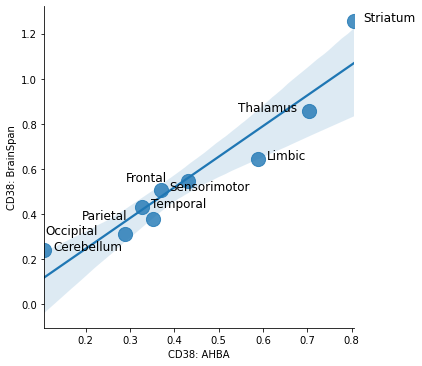

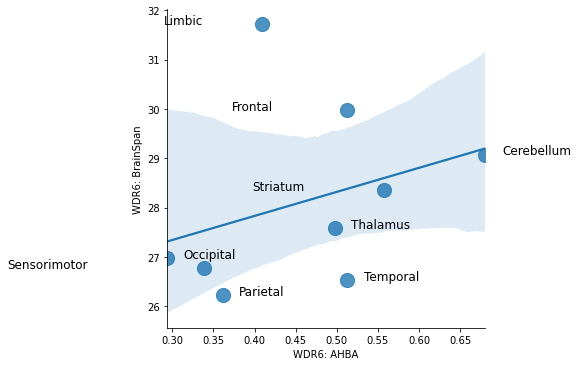

In [47]:
for col in pdcols:
    aba = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/GCorr_PDComp_PD_%s.csv'%col,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    bs = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='PD_%s'%col,
                             index='MacroStructure2',aggfunc=np.mean
                            )
    for div in bs.index:
        sem = gdf[gdf.MacroStructure2==div]['PD_%s'%col].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['BS_mean','BS_sem']
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = sharecols
    
    sns.lmplot(x='ABA_mean',y='BS_mean',data=comp,
           scatter_kws={'marker':'o','s':200}
           #hue='region',legend=False,fit_reg=False
          )
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        #xsem = c2_comp.loc[div,'ABA_sem']
        y = comp.loc[div,'BS_mean']
        #ysem = c2_comp.loc[div,'BS_sem']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x+.02, y,div,{'size':12})
        else:
            plt.text(x-dist, y,div,{'size':12},
                     )
    #     plt.plot([x-xsem,x+xsem],[y,y],c='k')
    #     plt.plot([x,x],[y-ysem,y+ysem],c='k')
    plt.xlabel('%s: AHBA'%col)
    plt.ylabel('%s: BrainSpan'%col)
    plt.show()

#### Individual subject matching

In [50]:
gpdfs = {}
for col in pdcols:
    gpdf = gdf[['donor_id','PD_%s'%col,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values='PD_%s'%col)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({col: gpdf})

In [51]:
print(gpdfs[col].shape)
gpdfs[col].head()

(42, 10)


MacroStructure2,Cerebellum,Frontal,Limbic,Occipital,Parietal,Sensorimotor,Striatum,Temporal,Thalamus,n_valid
donor_id,,,,,,,,,,
12287,NaN,51.579689,NaN,48.251437,45.370717,NaN,37.515342,51.696023,34.795782,6.0
12288,34.098249,43.044396,44.085051,45.713543,39.241286,43.398583,39.977199,40.797152,33.605793,9.0
12289,21.528960,14.658756,16.527994,10.957307,10.783586,12.936070,NaN,11.971065,NaN,7.0
12290,32.232991,24.783851,28.376772,18.947262,21.289244,19.016763,30.355817,24.059865,24.675263,9.0
12295,35.120532,46.377133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [52]:
gpdfs[col].n_valid.value_counts()

9.0    18
8.0     9
7.0     6
6.0     3
4.0     2
2.0     2
3.0     1
1.0     1
Name: n_valid, dtype: int64

In [53]:
for col in pdcols:
    cdf = gpdfs[col]
    aba = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/GCorr_PDComp_PD_%s.csv'%col,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-1]]
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 5:
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'%s_r'%col] = r
            cdf.loc[i,'%s_rho'%col] = rho

In [57]:
cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level', 'new_age_gp', 'new_age_stage','age_in_months',
       'log_age_months']

In [70]:
subsum = pandas.DataFrame(gpdfs['CD38'].index)
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().values
for col in pdcols:
    subsum.loc[:,'%s_r'%col] = gpdfs[col].loc[:,'%s_r'%col].values
    subsum.loc[:,'%s_rho'%col] = gpdfs[col].loc[:,'%s_rho'%col].values
    subsum.loc[:,'n_valid'] = gpdfs[col].loc[:,'n_valid'].values

r=0.592, p=0.0001


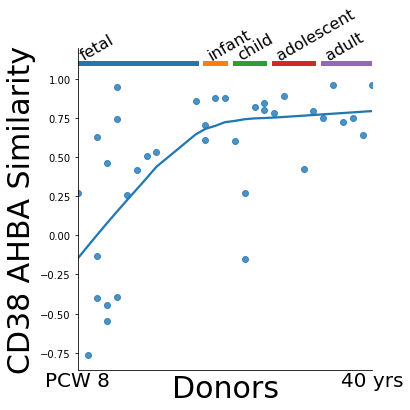

r=0.677, p=0.0


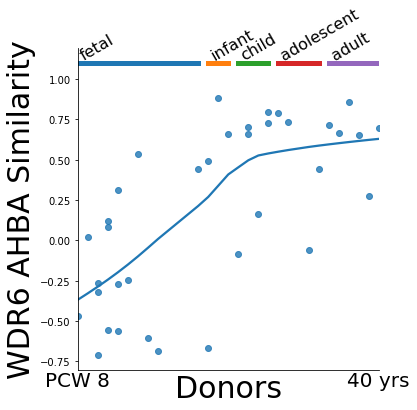

In [71]:
for col in pdcols:
    g=sns.lmplot(x='age_level',y='%s_r'%col,
                #hue='SEX',
                lowess=True,
               data=subsum)
    plotr = pandas.DataFrame(subsum[['%s_r'%col,'age_level']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['%s_r'%col].values,
                      plotr.age_level.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    g.set_xticklabels(rotation=90)
    g.set_xticklabels(rotation=90)
    for stage in gdf.Age_Stage.unique():
        levels = gdf[gdf.Age_Stage==stage]['age_level'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    plt.ylabel('%s AHBA Similarity'%col,fontsize=30)
    # plt.yticks([])
    plt.xlabel('Donors',fontsize=30)
    plt.xticks([])
    ymin = subsum['%s_r'%col].min() - 0.1
    plt.text(0,-0.05,'PCW 8',fontsize=20,ha='center',
         transform=g.ax.transAxes)
    plt.text(1,-0.05,'40 yrs',fontsize=20,ha='center',
             transform=g.ax.transAxes)
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/BrSp_CompR_C%s.pdf'%c,
#                bbox_inches='tight')
    plt.show()
    
#     # rho
#     g=sns.lmplot(x='age_level',y='C%s_rho'%c,
#                 #hue='SEX',
#                 lowess=True,
#                data=subsum)
#     plotr = pandas.DataFrame(subsum[['C%s_rho'%c,'age_level']],
#                             copy=True).dropna()
#     r,p=stats.pearsonr(plotr['C%s_rho'%c].values,
#                       plotr.age_level.values)
#     print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
#     g.set_xticklabels(rotation=90)
#     g.set_xticklabels(rotation=90)
#     for stage in gdf.Age_Stage.unique():
#         levels = gdf[gdf.Age_Stage==stage]['age_level'].values
#         xmin = np.min(levels)
#         xmax = np.max(levels)
#         plt.plot([xmin,xmax],[1.1,1.1],lw=5)
#         #loc = xmin + (xmax-xmin)*.5
#         plt.text(xmin,1.1,stage,fontsize=16,ha='left',
#                  va='bottom',rotation=30)
#     plt.ylabel('C%s Expression'%c,fontsize=30)
#     # plt.yticks([])
#     plt.xlabel('Donors',fontsize=30)
#     plt.xticks([])
#     ymin = subsum['C%s_r'%c].min() - 0.1
#     plt.text(0,-0.05,'PCW 8',fontsize=20,ha='center',
#          transform=g.ax.transAxes)
#     plt.text(1,-0.05,'40 yrs',fontsize=20,ha='center',
#              transform=g.ax.transAxes)
#     plt.show()
